## White Box Attack on Trained DP-Promise Model (CelebA 64 - eps 1, 5, & 10)

In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import Subset
import numpy as np
from src.trainers import DPPromiseTrainer
import pandas as pd
import torch.nn.functional as F

# Now import custom modules
#from src.datasets import CustomImageDataset
from src.utils import get_unet_model, seed_everthing
from src.samplers import DDIMSampler

import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "Celeba64_Eps1"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

from PIL import Image

# --- Settings ---

member_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
nonmember_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
config_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/configs/dp_promise/celeba_64/eps1.0/config.yaml"
ckpt_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps1.0_celeba64_eps1.0_0803-05:32:50/checkpoints/ema_15.ckpt"

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📡 Using device: {device}")

# --- Config ---
config = OmegaConf.load(config_path)
seed_everthing(config.train.seed)

trainer = DPPromiseTrainer(config).to(device)

# --- Data Transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0, exclude_files=None):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label

        all_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Normalize exclude_files outside the if
        exclude_set = set(f.strip().lower() for f in exclude_files) if exclude_files else set()

        # Exclude files
        filtered_files = [f for f in all_files if f.strip().lower() not in exclude_set]

        self.image_paths = [os.path.join(image_dir, fname) for fname in filtered_files]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label


overlapping_nonmember_filenames = set([
    "165328.png" , "165694.png" , "166223.png" , "166493.png" , "166699.png" , "167671.png" , "168391.png" ,
    "168593.png" , "169496.png" , "170471.png" , "170604.png" , "170718.png" , "172963.png" , "173340.png" ,
    "175461.png" , "175527.png" , "176462.png" , "177540.png" , "177827.png" , "178379.png" , "179890.png" ,
    "180110.png" , "180455.png" , "180718.png" , "183407.png" , "183446.png" , "183954.png" , "186879.png" ,
    "187543.png" , "189148.png" , "194183.png" , "194529.png" , "195526.png" , "195916.png" , "197808.png" ])

# --- Load Datasets ---

nonmember_dataset = CustomImageDataset(nonmember_path, transform=transform, label=0, exclude_files= overlapping_nonmember_filenames)
member_dataset = CustomImageDataset(member_path, transform=transform, label=1)

# --- Dataset Stats & Sanity Check ---

def print_dataset_summary(dataset, name):
    print(f"\n📊 Dataset: {name}")
    print(f"   Total images loaded: {len(dataset)}")
    print(f"   First 5 image paths:")
    for path in dataset.image_paths[:5]:
        print(f"     - {os.path.basename(path)}")

print_dataset_summary(member_dataset, "Member")
print_dataset_summary(nonmember_dataset, "Non-Member")

# Double check: ensure no overlapping files in nonmember_dataset
nonmember_filenames = set(os.path.basename(p).lower().strip() for p in nonmember_dataset.image_paths)
remaining_overlap = nonmember_filenames & overlapping_nonmember_filenames
print(f"\n🚨 Remaining overlaps in Non-Member dataset: {remaining_overlap if remaining_overlap else 'None'}")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to use
sample_size = 40000

# Sample member indices
member_indices = np.random.choice(len(member_dataset), size=sample_size, replace=False)
balanced_member_dataset = Subset(member_dataset, member_indices)
member_loader = DataLoader(balanced_member_dataset, batch_size=32, shuffle=False)

# Sample non-member indices
nonmember_indices = np.random.choice(len(nonmember_dataset), size=sample_size, replace=False)
balanced_nonmember_dataset = Subset(nonmember_dataset, nonmember_indices)
nonmember_loader = DataLoader(balanced_nonmember_dataset, batch_size=32, shuffle=False)

#member_loader = DataLoader(member_dataset, batch_size=512, shuffle=False)
#nonmember_loader = DataLoader(nonmember_dataset, batch_size=512, shuffle=False)

# --- Load Model ---
model = get_unet_model(config).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"] if "state_dict" in ckpt else ckpt)
model.eval()

# --- Sampler ---
sampler = DDIMSampler(config)

import torch.nn.functional as F

def get_mia_scores_loss(images, labels, model, sampler, config, device, t_val):
    model.eval()
    scores = []
    batch_size = 64

    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(0, images.size(0), batch_size):
        img_batch = images[i:i+batch_size]
        lbl_batch = labels[i:i+batch_size]

        t = torch.full((img_batch.size(0),), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img_batch)
        noisy_img = trainer.q_sample(img_batch, t, noise)

        with torch.no_grad():
            preds = model(noisy_img, t, y=lbl_batch)

        loss = F.mse_loss(preds, noise, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        scores.extend((-loss).cpu().numpy())

    return scores

# --- Score Extraction ---

def get_all_scores(loader, t_val):
    all_scores = []
    all_labels = []
    for images, labels in tqdm(loader, desc=f"🔄 Processing batches @ t={t_val}"):
        scores = get_mia_scores_loss(images, labels, model, sampler, config, device, t_val)
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    return all_scores, all_labels

@torch.no_grad()
def predict_start_from_noise(x_t, t, noise, alphas_cumprod):
    alphas_cumprod = alphas_cumprod.to(x_t.device)

    # Clamp t to max-1 to avoid out-of-bounds access
    t_safe = torch.clamp(t, max=alphas_cumprod.shape[0] - 2)

    sqrt_alphas_cumprod = alphas_cumprod[t_safe + 1].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t_safe + 1]).sqrt().view(-1, 1, 1, 1)

    return (x_t - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod


def visualize_reconstruction(img, label, model, trainer, t_vals, alphas_cumprod, title_prefix="", save_path="Reconstruction.png"):
    model.eval()
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    num_plots = len(t_vals) + 1  # +1 for original
    num_rows = 4
    num_cols = math.ceil(num_plots / num_rows)  # calculate columns automatically

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axs = axs.flatten()  # flatten to simplify indexing

    # Original image
    axs[0].imshow(((img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
    axs[0].set_title("Original", fontweight='bold')
    axs[0].axis("off")

    # Reconstructions
    for i, t_val in enumerate(t_vals): 
        t = torch.full((1,), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img)
        noisy_img = trainer.q_sample(img, t, noise)

        with torch.no_grad():
            pred_noise = model(noisy_img, t, y=label)

        recon_img = predict_start_from_noise(noisy_img, t, pred_noise, alphas_cumprod)
        axs[i + 1].imshow(((recon_img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
        axs[i + 1].set_title(f"t = {t_val}", fontweight='bold')
        axs[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(num_plots, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"{title_prefix} Reconstruction Over Timesteps", fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() 

timesteps_to_eval = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
results = []
# Store all ROC curves for final combined plot
roc_curves = []  # each element will be (fpr, tpr, auc, timestep)
# For histogram subplots
histogram_data = []  # (timestep, member_scores, nonmember_scores)


for t_val in timesteps_to_eval:
    print(f"\n⏱️ Evaluating timestep t = {t_val}")

    member_scores, member_labels = get_all_scores(member_loader, t_val)
    nonmember_scores, nonmember_labels = get_all_scores(nonmember_loader, t_val)

    y_true = [1]*len(member_scores) + [0]*len(nonmember_scores)
    y_score = member_scores + nonmember_scores

    # Append to list for saving later
    timestep_df = pd.DataFrame({
        "timestep": [t_val] * len(y_true),
        "label": y_true,
        "score": y_score
    })
    all_timestep_data.append(timestep_df)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"📈 AUC @ t={t_val}: {auc:.4f}")
    results.append({"timestep": t_val, "auc": auc})
    roc_curves.append((fpr, tpr, auc, t_val))

    histogram_data.append((t_val, member_scores, nonmember_scores))

# After loop — save all timesteps in ONE worksheet
final_df = pd.concat(all_timestep_data, ignore_index=True)

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA64_Eps1")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("Celeba64_Eps1_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("Celeba64_Eps1_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA64_Eps1", save_path="Celeba64_Eps1_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA64_Eps1", save_path="Celeba64_Eps1_Non_Member_Recon.png"
)

📡 Using device: cuda

📊 Dataset: Member
   Total images loaded: 162079
   First 5 image paths:
     - 061848.png
     - 009741.png
     - 055030.png
     - 115863.png
     - 046888.png

📊 Dataset: Non-Member
   Total images loaded: 40485
   First 5 image paths:
     - 168189.png
     - 165346.png
     - 188320.png
     - 168762.png
     - 176095.png

🚨 Remaining overlaps in Non-Member dataset: None


/tmp/ipykernel_594303/4203722962.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



⏱️ Evaluating timestep t = 0


🔄 Processing batches @ t=0: 100%|██████████| 1250/1250 [10:44<00:00,  1.94it/s]


📈 AUC @ t=0: 0.6568

⏱️ Evaluating timestep t = 100


🔄 Processing batches @ t=100: 100%|██████████| 1250/1250 [09:54<00:00,  2.10it/s]


📈 AUC @ t=100: 0.9181

⏱️ Evaluating timestep t = 200


🔄 Processing batches @ t=200: 100%|██████████| 1250/1250 [09:02<00:00,  2.31it/s]


📈 AUC @ t=200: 0.8555

⏱️ Evaluating timestep t = 300


🔄 Processing batches @ t=300: 100%|██████████| 1250/1250 [12:08<00:00,  1.72it/s]


📈 AUC @ t=300: 0.7365

⏱️ Evaluating timestep t = 400


🔄 Processing batches @ t=400: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s]


📈 AUC @ t=400: 0.6489

⏱️ Evaluating timestep t = 500


🔄 Processing batches @ t=500: 100%|██████████| 1250/1250 [09:41<00:00,  2.15it/s]


📈 AUC @ t=500: 0.6140

⏱️ Evaluating timestep t = 600


🔄 Processing batches @ t=600: 100%|██████████| 1250/1250 [10:02<00:00,  2.07it/s]


📈 AUC @ t=600: 0.6272

⏱️ Evaluating timestep t = 700


🔄 Processing batches @ t=700: 100%|██████████| 1250/1250 [09:07<00:00,  2.28it/s]


📈 AUC @ t=700: 0.7186

⏱️ Evaluating timestep t = 800


🔄 Processing batches @ t=800: 100%|██████████| 1250/1250 [09:12<00:00,  2.26it/s]


📈 AUC @ t=800: 0.9337

⏱️ Evaluating timestep t = 900


🔄 Processing batches @ t=900: 100%|██████████| 1250/1250 [09:29<00:00,  2.20it/s]


📈 AUC @ t=900: 0.9988

⏱️ Evaluating timestep t = 999


🔄 Processing batches @ t=999: 100%|██████████| 1250/1250 [09:07<00:00,  2.28it/s]


📈 AUC @ t=999: 0.9998


BadZipFile: Bad CRC-32 for file 'xl/worksheets/sheet1.xml'

✅ All timestep scores saved to 'WhiteBoxAttack.xlsx' in sheet 'Celeba64_Eps1'

📊 AUC Scores by Timestep:
               auc
timestep          
0         0.656815
100       0.918089
200       0.855499
300       0.736527
400       0.648889
500       0.613986
600       0.627188
700       0.718573
800       0.933680
900       0.998776
999       0.999828


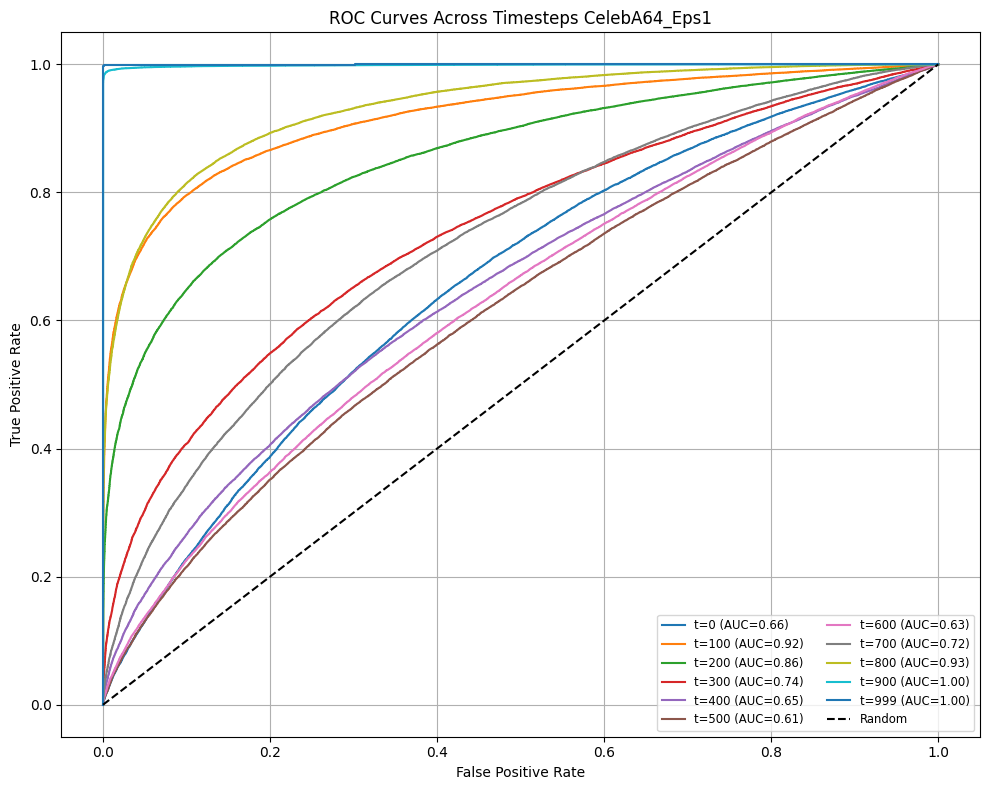

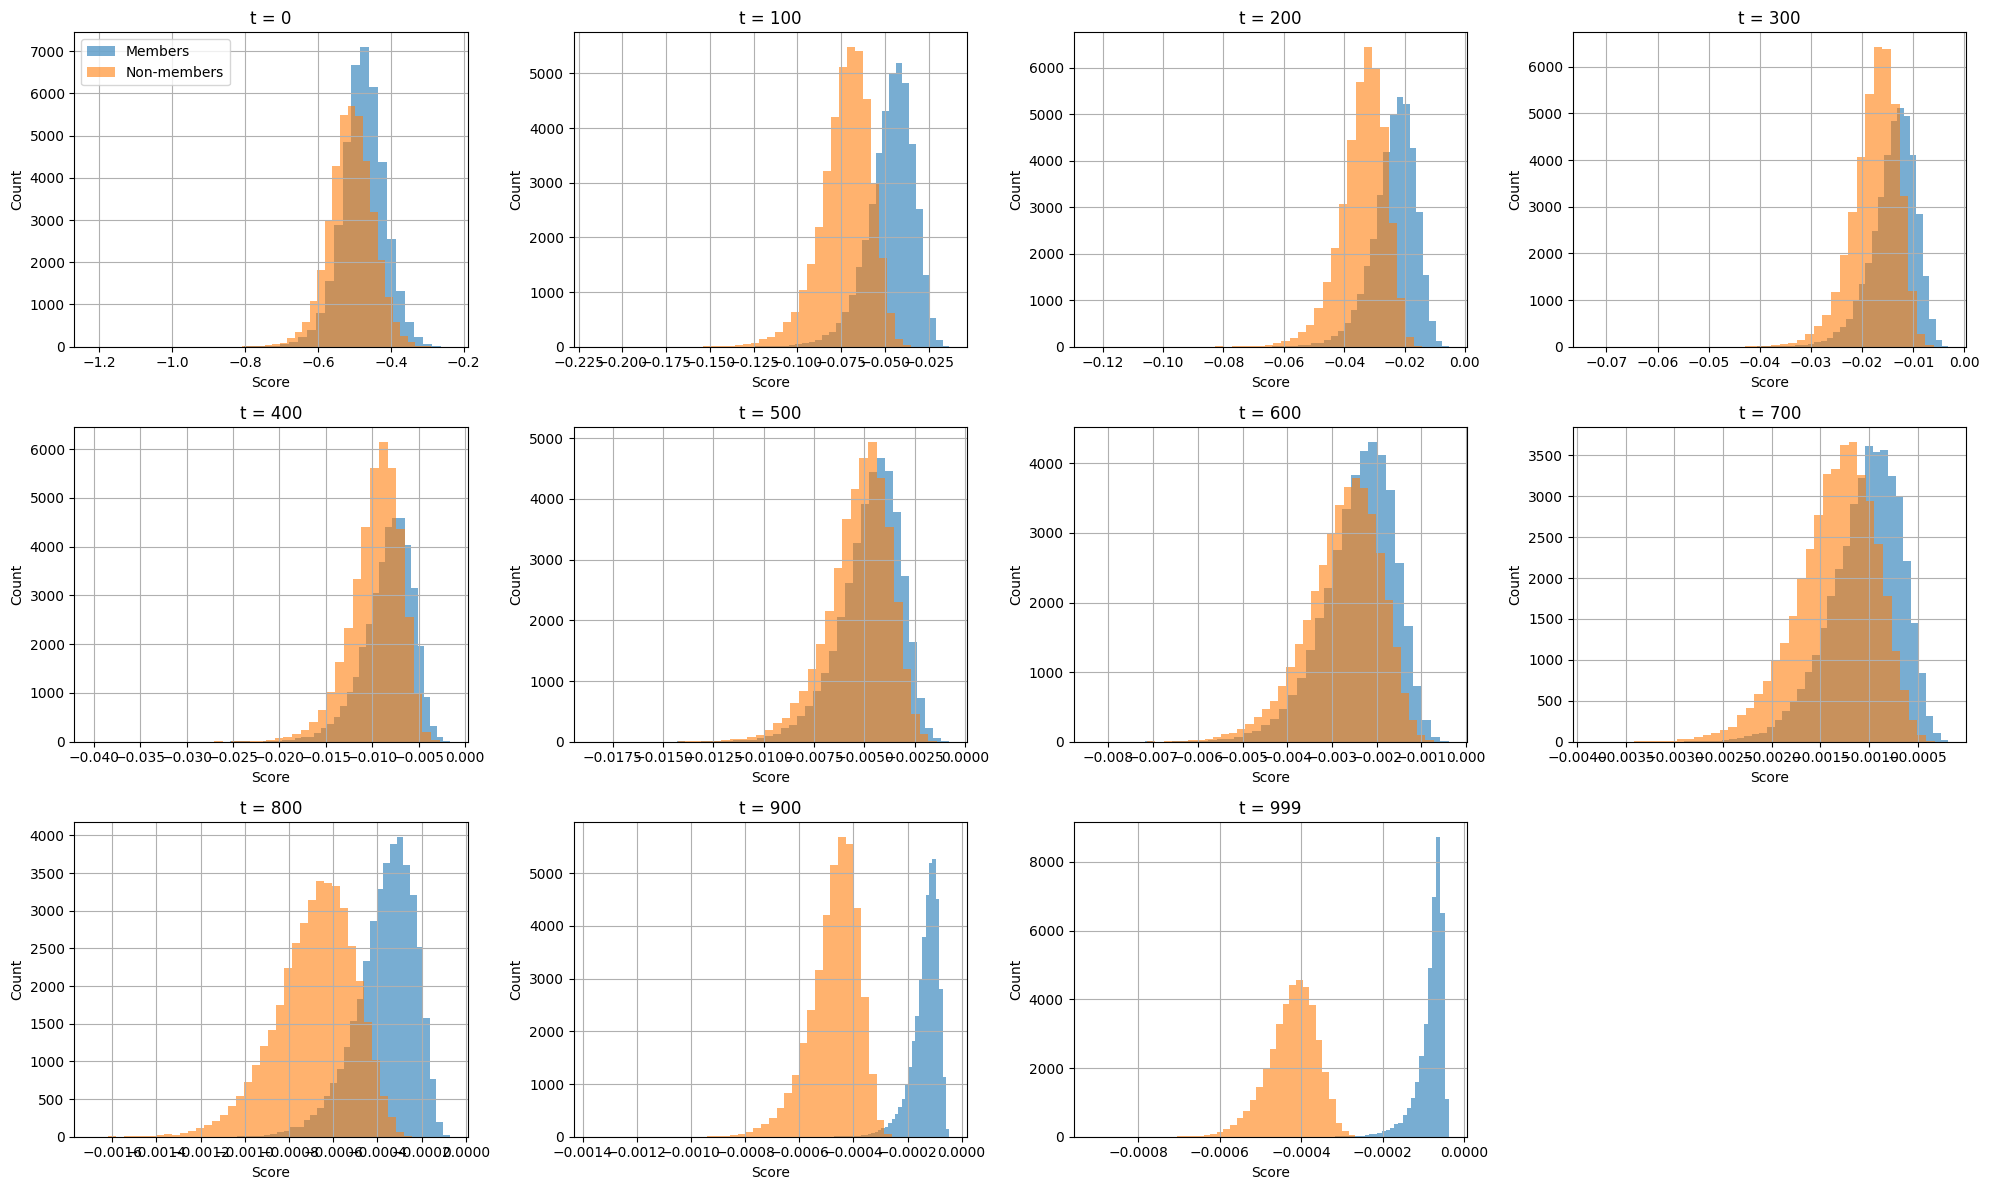


🖼️ Visualizing MEMBER sample


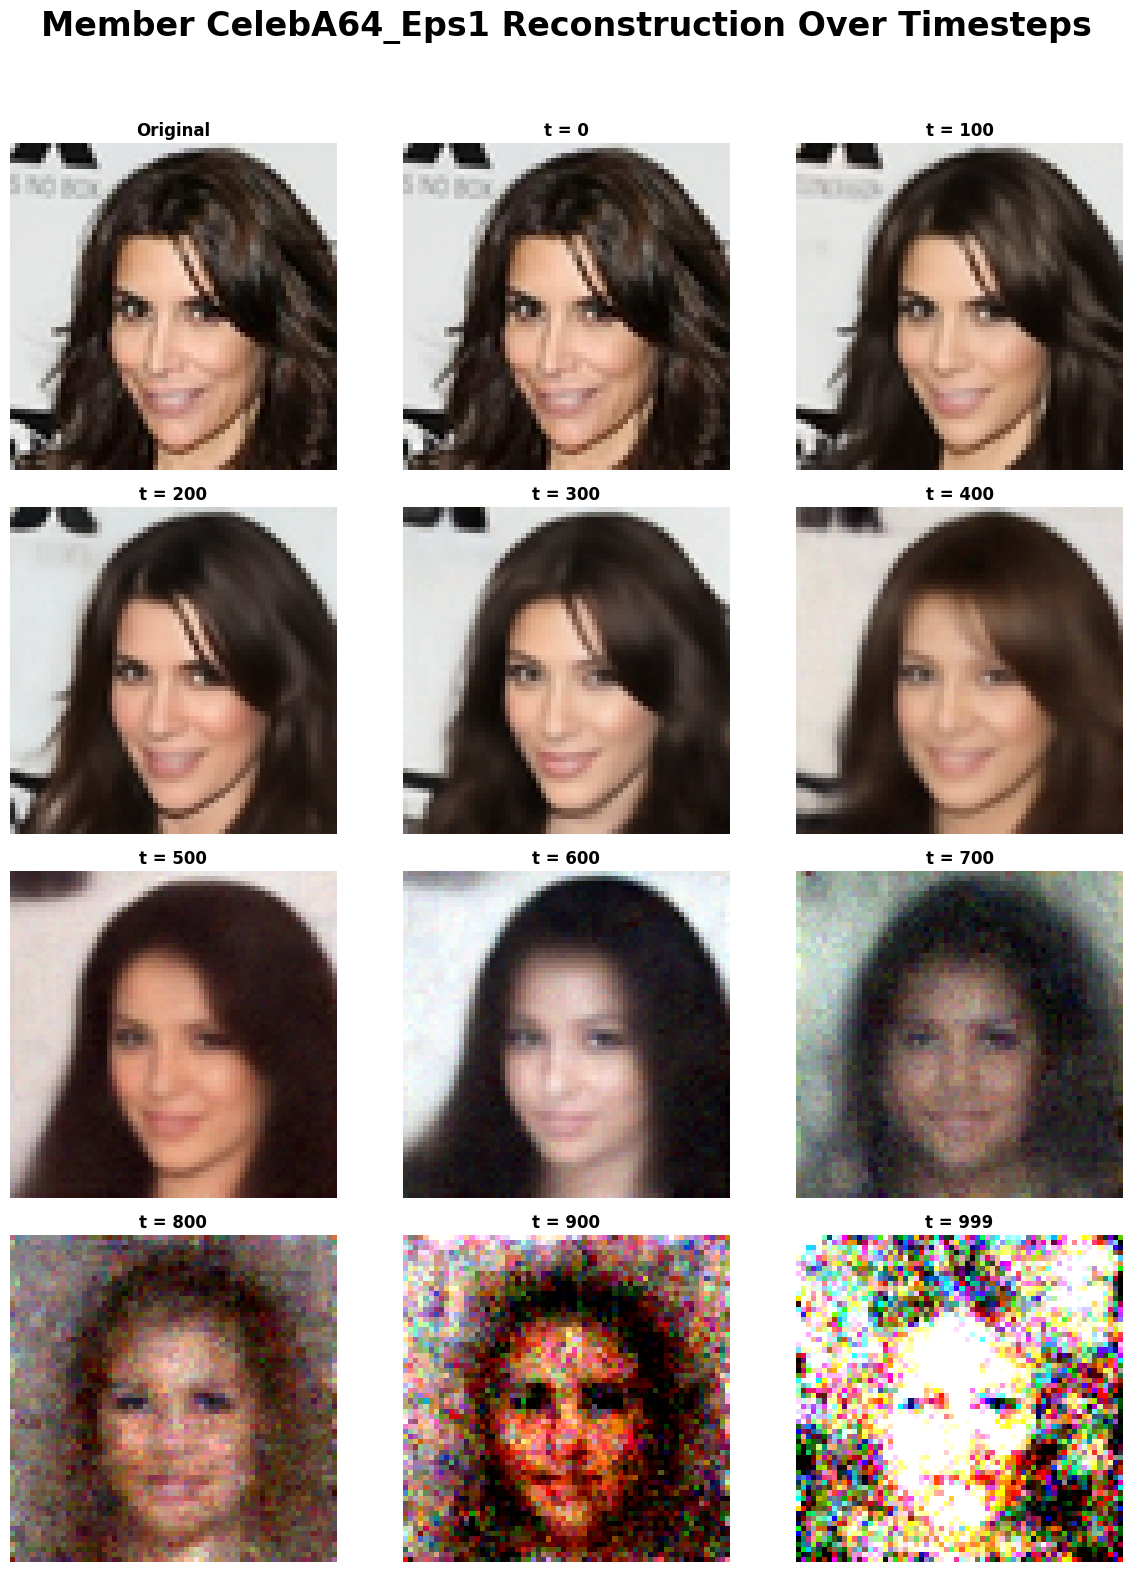


🖼️ Visualizing Non MEMBER sample


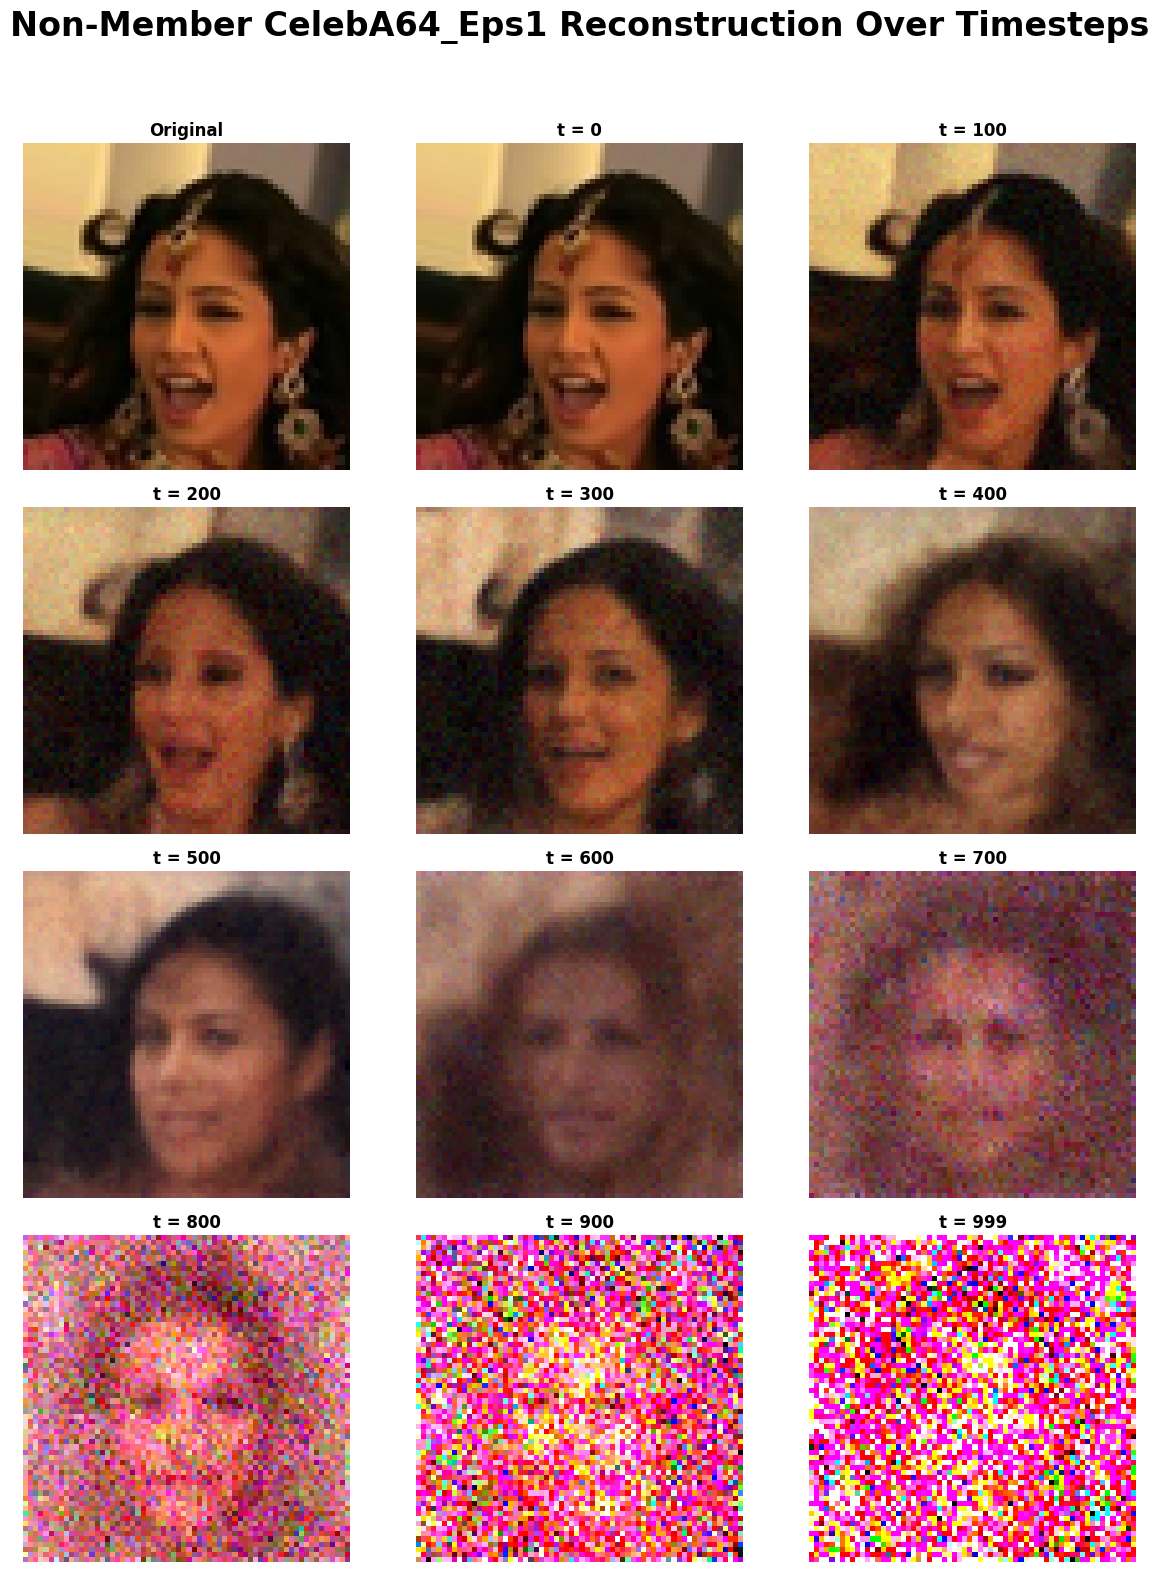

In [9]:
import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "Celeba64_Eps1"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA64_Eps1")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("Celeba64_Eps1_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("Celeba64_Eps1_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA64_Eps1", save_path="Celeba64_Eps1_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA64_Eps1", save_path="Celeba64_Eps1_Non_Member_Recon.png"
)

In [25]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import Subset
import numpy as np
from src.trainers import DPPromiseTrainer
import pandas as pd
import torch.nn.functional as F

# Now import custom modules
#from src.datasets import CustomImageDataset
from src.utils import get_unet_model, seed_everthing
from src.samplers import DDIMSampler

import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "CelebA64_Eps5"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

from PIL import Image

# --- Settings ---

member_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
nonmember_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
config_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/configs/dp_promise/celeba_64/eps5.0/config.yaml"
ckpt_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps5.0_celeba64_eps5.0_0809-20:46:35/checkpoints/ema_15.ckpt"

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📡 Using device: {device}")

# --- Config ---
config = OmegaConf.load(config_path)
seed_everthing(config.train.seed)

trainer = DPPromiseTrainer(config).to(device)

# --- Data Transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0, exclude_files=None):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label

        all_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Normalize exclude_files outside the if
        exclude_set = set(f.strip().lower() for f in exclude_files) if exclude_files else set()

        # Exclude files
        filtered_files = [f for f in all_files if f.strip().lower() not in exclude_set]

        self.image_paths = [os.path.join(image_dir, fname) for fname in filtered_files]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label


overlapping_nonmember_filenames = set([
    "165328.png" , "165694.png" , "166223.png" , "166493.png" , "166699.png" , "167671.png" , "168391.png" ,
    "168593.png" , "169496.png" , "170471.png" , "170604.png" , "170718.png" , "172963.png" , "173340.png" ,
    "175461.png" , "175527.png" , "176462.png" , "177540.png" , "177827.png" , "178379.png" , "179890.png" ,
    "180110.png" , "180455.png" , "180718.png" , "183407.png" , "183446.png" , "183954.png" , "186879.png" ,
    "187543.png" , "189148.png" , "194183.png" , "194529.png" , "195526.png" , "195916.png" , "197808.png" ])

# --- Load Datasets ---

nonmember_dataset = CustomImageDataset(nonmember_path, transform=transform, label=0, exclude_files= overlapping_nonmember_filenames)
member_dataset = CustomImageDataset(member_path, transform=transform, label=1)

# --- Dataset Stats & Sanity Check ---

def print_dataset_summary(dataset, name):
    print(f"\n📊 Dataset: {name}")
    print(f"   Total images loaded: {len(dataset)}")
    print(f"   First 5 image paths:")
    for path in dataset.image_paths[:5]:
        print(f"     - {os.path.basename(path)}")

print_dataset_summary(member_dataset, "Member")
print_dataset_summary(nonmember_dataset, "Non-Member")

# Double check: ensure no overlapping files in nonmember_dataset
nonmember_filenames = set(os.path.basename(p).lower().strip() for p in nonmember_dataset.image_paths)
remaining_overlap = nonmember_filenames & overlapping_nonmember_filenames
print(f"\n🚨 Remaining overlaps in Non-Member dataset: {remaining_overlap if remaining_overlap else 'None'}")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to use
sample_size = 40000

# Sample member indices
member_indices = np.random.choice(len(member_dataset), size=sample_size, replace=False)
balanced_member_dataset = Subset(member_dataset, member_indices)
member_loader = DataLoader(balanced_member_dataset, batch_size=32, shuffle=False)

# Sample non-member indices
nonmember_indices = np.random.choice(len(nonmember_dataset), size=sample_size, replace=False)
balanced_nonmember_dataset = Subset(nonmember_dataset, nonmember_indices)
nonmember_loader = DataLoader(balanced_nonmember_dataset, batch_size=32, shuffle=False)

#member_loader = DataLoader(member_dataset, batch_size=512, shuffle=False)
#nonmember_loader = DataLoader(nonmember_dataset, batch_size=512, shuffle=False)

# --- Load Model ---
model = get_unet_model(config).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"] if "state_dict" in ckpt else ckpt)
model.eval()

# --- Sampler ---
sampler = DDIMSampler(config)

import torch.nn.functional as F

def get_mia_scores_loss(images, labels, model, sampler, config, device, t_val):
    model.eval()
    scores = []
    batch_size = 64

    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(0, images.size(0), batch_size):
        img_batch = images[i:i+batch_size]
        lbl_batch = labels[i:i+batch_size]

        t = torch.full((img_batch.size(0),), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img_batch)
        noisy_img = trainer.q_sample(img_batch, t, noise)

        with torch.no_grad():
            preds = model(noisy_img, t, y=lbl_batch)

        loss = F.mse_loss(preds, noise, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        scores.extend((-loss).cpu().numpy())

    return scores

# --- Score Extraction ---

def get_all_scores(loader, t_val):
    all_scores = []
    all_labels = []
    for images, labels in tqdm(loader, desc=f"🔄 Processing batches @ t={t_val}"):
        scores = get_mia_scores_loss(images, labels, model, sampler, config, device, t_val)
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    return all_scores, all_labels

@torch.no_grad()
def predict_start_from_noise(x_t, t, noise, alphas_cumprod):
    alphas_cumprod = alphas_cumprod.to(x_t.device)

    # Clamp t to max-1 to avoid out-of-bounds access
    t_safe = torch.clamp(t, max=alphas_cumprod.shape[0] - 2)

    sqrt_alphas_cumprod = alphas_cumprod[t_safe + 1].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t_safe + 1]).sqrt().view(-1, 1, 1, 1)

    return (x_t - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod


def visualize_reconstruction(img, label, model, trainer, t_vals, alphas_cumprod, title_prefix="", save_path="Reconstruction.png"):
    model.eval()
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    num_plots = len(t_vals) + 1  # +1 for original
    num_rows = 4
    num_cols = math.ceil(num_plots / num_rows)  # calculate columns automatically

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axs = axs.flatten()  # flatten to simplify indexing

    # Original image
    axs[0].imshow(((img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
    axs[0].set_title("Original", fontweight='bold')
    axs[0].axis("off")

    # Reconstructions
    for i, t_val in enumerate(t_vals): 
        t = torch.full((1,), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img)
        noisy_img = trainer.q_sample(img, t, noise)

        with torch.no_grad():
            pred_noise = model(noisy_img, t, y=label)

        recon_img = predict_start_from_noise(noisy_img, t, pred_noise, alphas_cumprod)
        axs[i + 1].imshow(((recon_img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
        axs[i + 1].set_title(f"t = {t_val}", fontweight='bold')
        axs[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(num_plots, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"{title_prefix} Reconstruction Over Timesteps", fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() 

timesteps_to_eval = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
results = []
# Store all ROC curves for final combined plot
roc_curves = []  # each element will be (fpr, tpr, auc, timestep)
# For histogram subplots
histogram_data = []  # (timestep, member_scores, nonmember_scores)


for t_val in timesteps_to_eval:
    print(f"\n⏱️ Evaluating timestep t = {t_val}")

    member_scores, member_labels = get_all_scores(member_loader, t_val)
    nonmember_scores, nonmember_labels = get_all_scores(nonmember_loader, t_val)

    y_true = [1]*len(member_scores) + [0]*len(nonmember_scores)
    y_score = member_scores + nonmember_scores

    # Append to list for saving later
    timestep_df = pd.DataFrame({
        "timestep": [t_val] * len(y_true),
        "label": y_true,
        "score": y_score
    })
    all_timestep_data.append(timestep_df)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"📈 AUC @ t={t_val}: {auc:.4f}")
    results.append({"timestep": t_val, "auc": auc})
    roc_curves.append((fpr, tpr, auc, t_val))

    histogram_data.append((t_val, member_scores, nonmember_scores))

# After loop — save all timesteps in ONE worksheet
final_df = pd.concat(all_timestep_data, ignore_index=True)

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA64_Eps5")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("CelebA64_Eps5_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("CelebA64_Eps5_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA64_Eps5", save_path="CelebA64_Eps5_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA64_Eps5", save_path="CelebA64_Eps5_Non_Member_Recon.png"
)

📡 Using device: cuda

📊 Dataset: Member
   Total images loaded: 162079
   First 5 image paths:
     - 061848.png
     - 009741.png
     - 055030.png
     - 115863.png
     - 046888.png

📊 Dataset: Non-Member
   Total images loaded: 40485
   First 5 image paths:
     - 168189.png
     - 165346.png
     - 188320.png
     - 168762.png
     - 176095.png

🚨 Remaining overlaps in Non-Member dataset: None


/tmp/ipykernel_3047596/146156089.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



⏱️ Evaluating timestep t = 0


🔄 Processing batches @ t=0: 100%|██████████| 1250/1250 [10:44<00:00,  1.94it/s]


📈 AUC @ t=0: 0.6448

⏱️ Evaluating timestep t = 100


🔄 Processing batches @ t=100: 100%|██████████| 1250/1250 [09:54<00:00,  2.10it/s]


📈 AUC @ t=100: 0.9083

⏱️ Evaluating timestep t = 200


🔄 Processing batches @ t=200: 100%|██████████| 1250/1250 [09:02<00:00,  2.31it/s]


📈 AUC @ t=200: 0.8441

⏱️ Evaluating timestep t = 300


🔄 Processing batches @ t=300: 100%|██████████| 1250/1250 [12:08<00:00,  1.72it/s]


📈 AUC @ t=300: 0.7266

⏱️ Evaluating timestep t = 400


🔄 Processing batches @ t=400: 100%|██████████| 1250/1250 [10:10<00:00,  2.05it/s]


📈 AUC @ t=400: 0.6474

⏱️ Evaluating timestep t = 500


🔄 Processing batches @ t=500: 100%|██████████| 1250/1250 [09:41<00:00,  2.15it/s]


📈 AUC @ t=500: 0.6179

⏱️ Evaluating timestep t = 600


🔄 Processing batches @ t=600: 100%|██████████| 1250/1250 [10:02<00:00,  2.07it/s]


📈 AUC @ t=600: 0.6244

⏱️ Evaluating timestep t = 700


🔄 Processing batches @ t=700: 100%|██████████| 1250/1250 [09:07<00:00,  2.28it/s]


📈 AUC @ t=700: 0.7239

⏱️ Evaluating timestep t = 800


🔄 Processing batches @ t=800: 100%|██████████| 1250/1250 [09:12<00:00,  2.26it/s]


📈 AUC @ t=800: 0.9354

⏱️ Evaluating timestep t = 900


🔄 Processing batches @ t=900: 100%|██████████| 1250/1250 [09:29<00:00,  2.20it/s]


📈 AUC @ t=900: 0.9997

⏱️ Evaluating timestep t = 999


🔄 Processing batches @ t=999: 100%|██████████| 1250/1250 [09:07<00:00,  2.28it/s]


📈 AUC @ t=999: 1.0000


BadZipFile: Bad CRC-32 for file 'xl/worksheets/sheet1.xml'

✅ All timestep scores saved to 'WhiteBoxAttack.xlsx' in sheet 'CelebA64_Eps5'

📊 AUC Scores by Timestep:
               auc
timestep          
0         0.644833
100       0.908265
200       0.844050
300       0.726616
400       0.647351
500       0.617864
600       0.624428
700       0.723940
800       0.935404
900       0.999680
999       1.000000


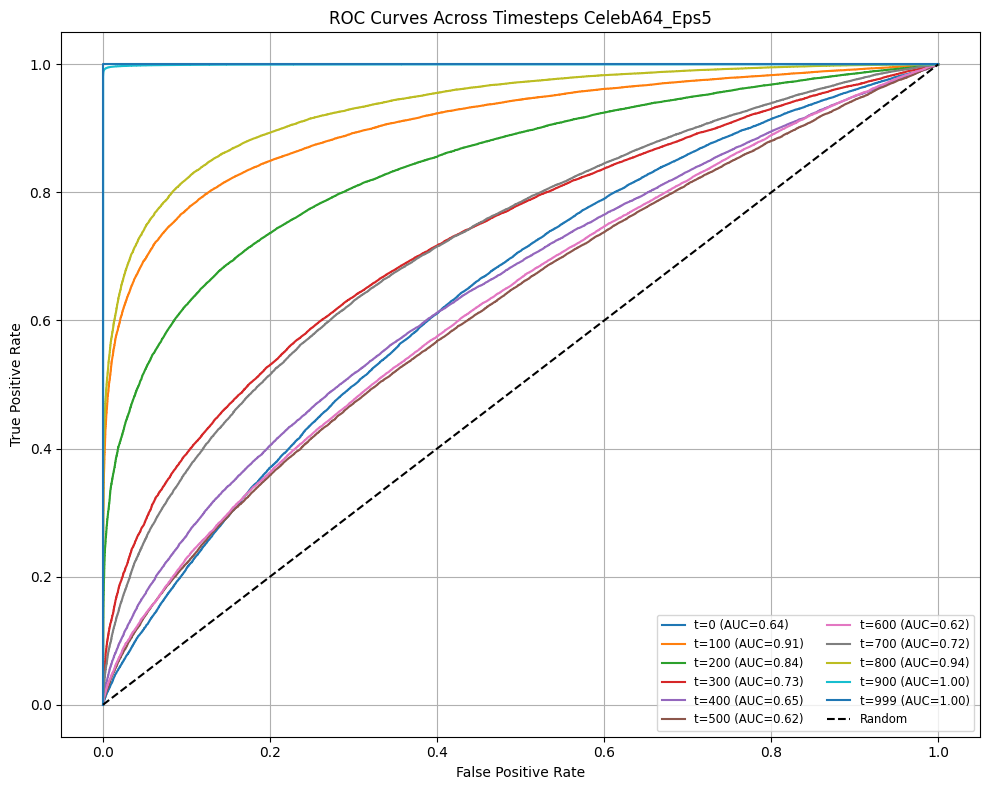

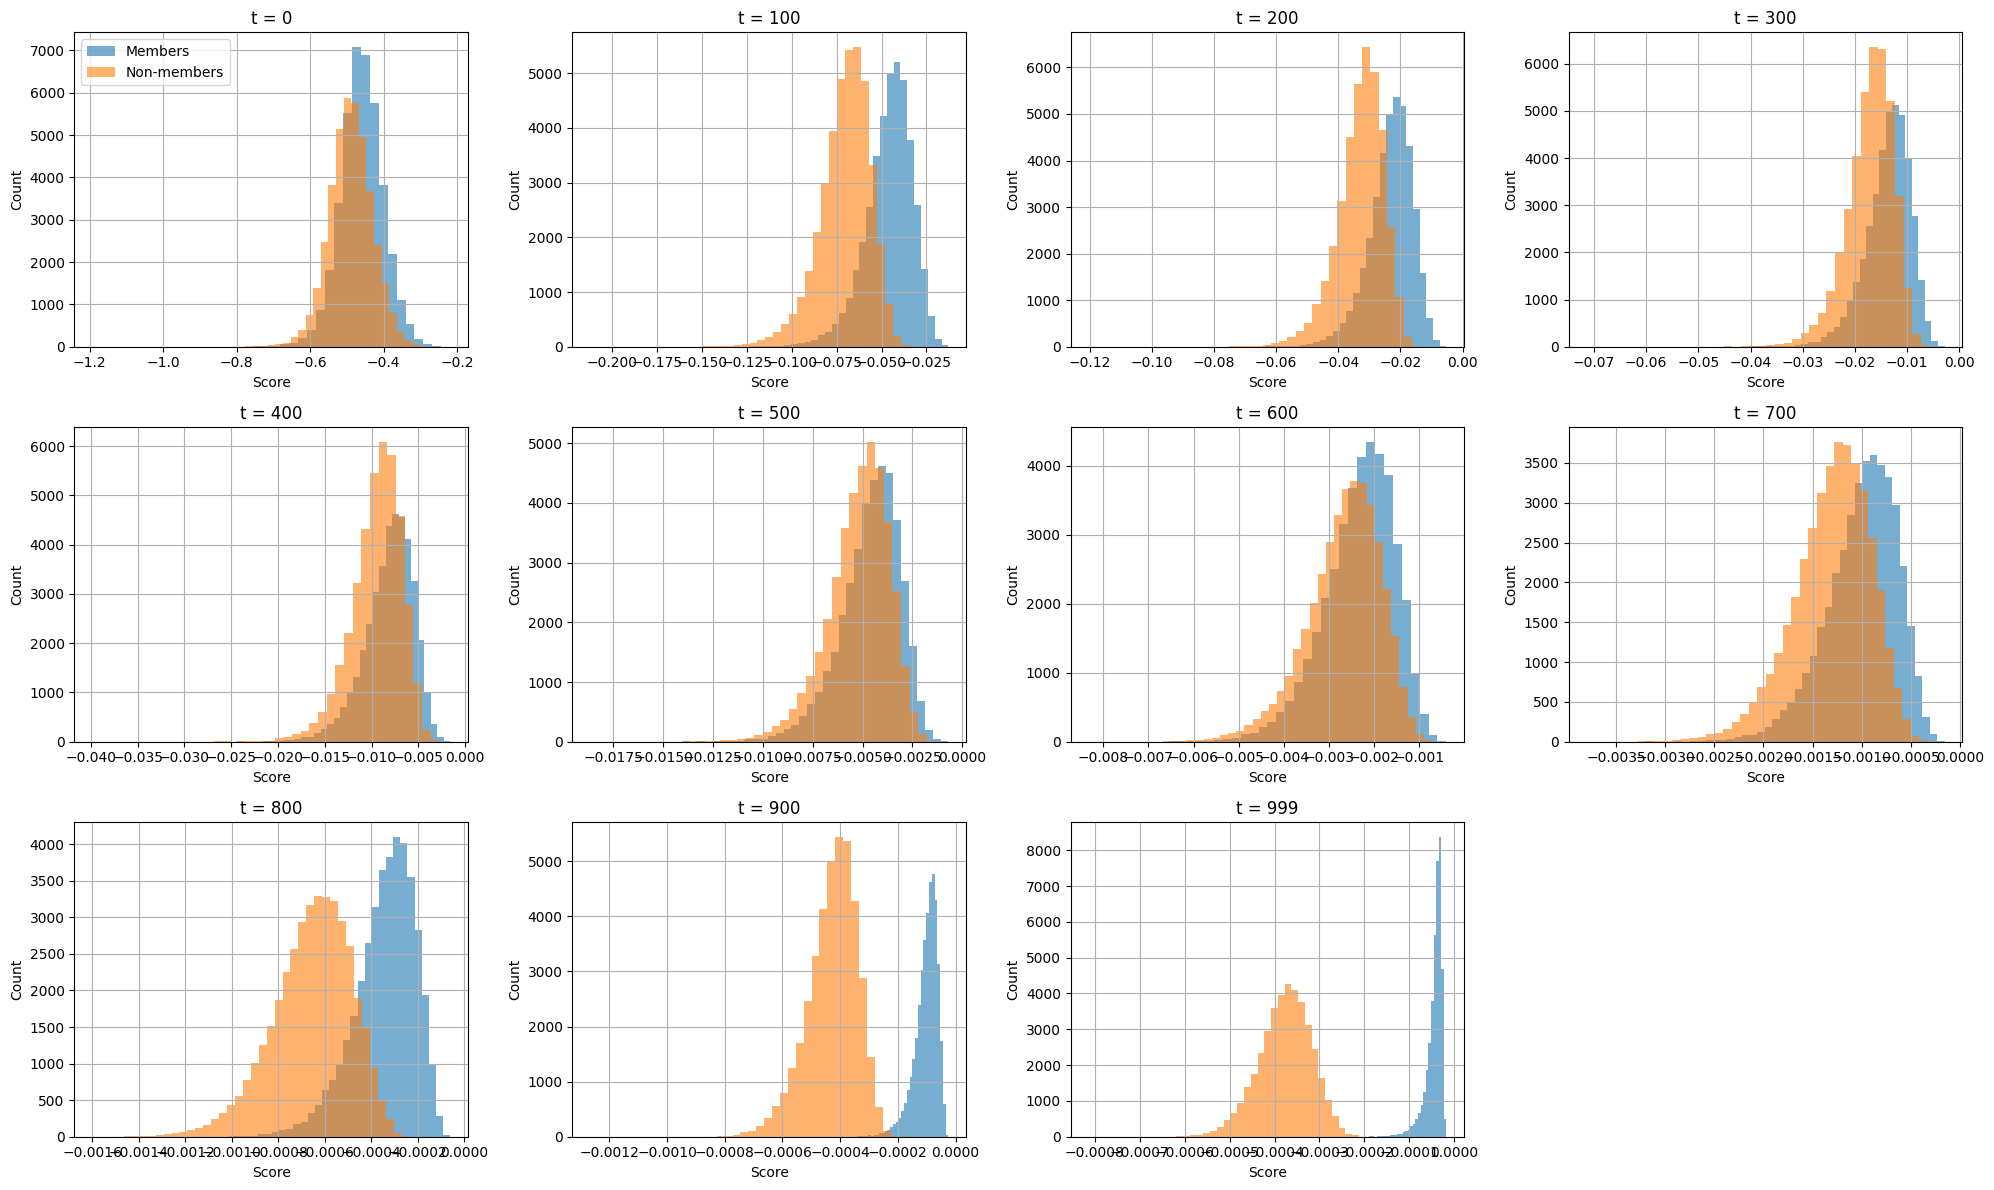


🖼️ Visualizing MEMBER sample


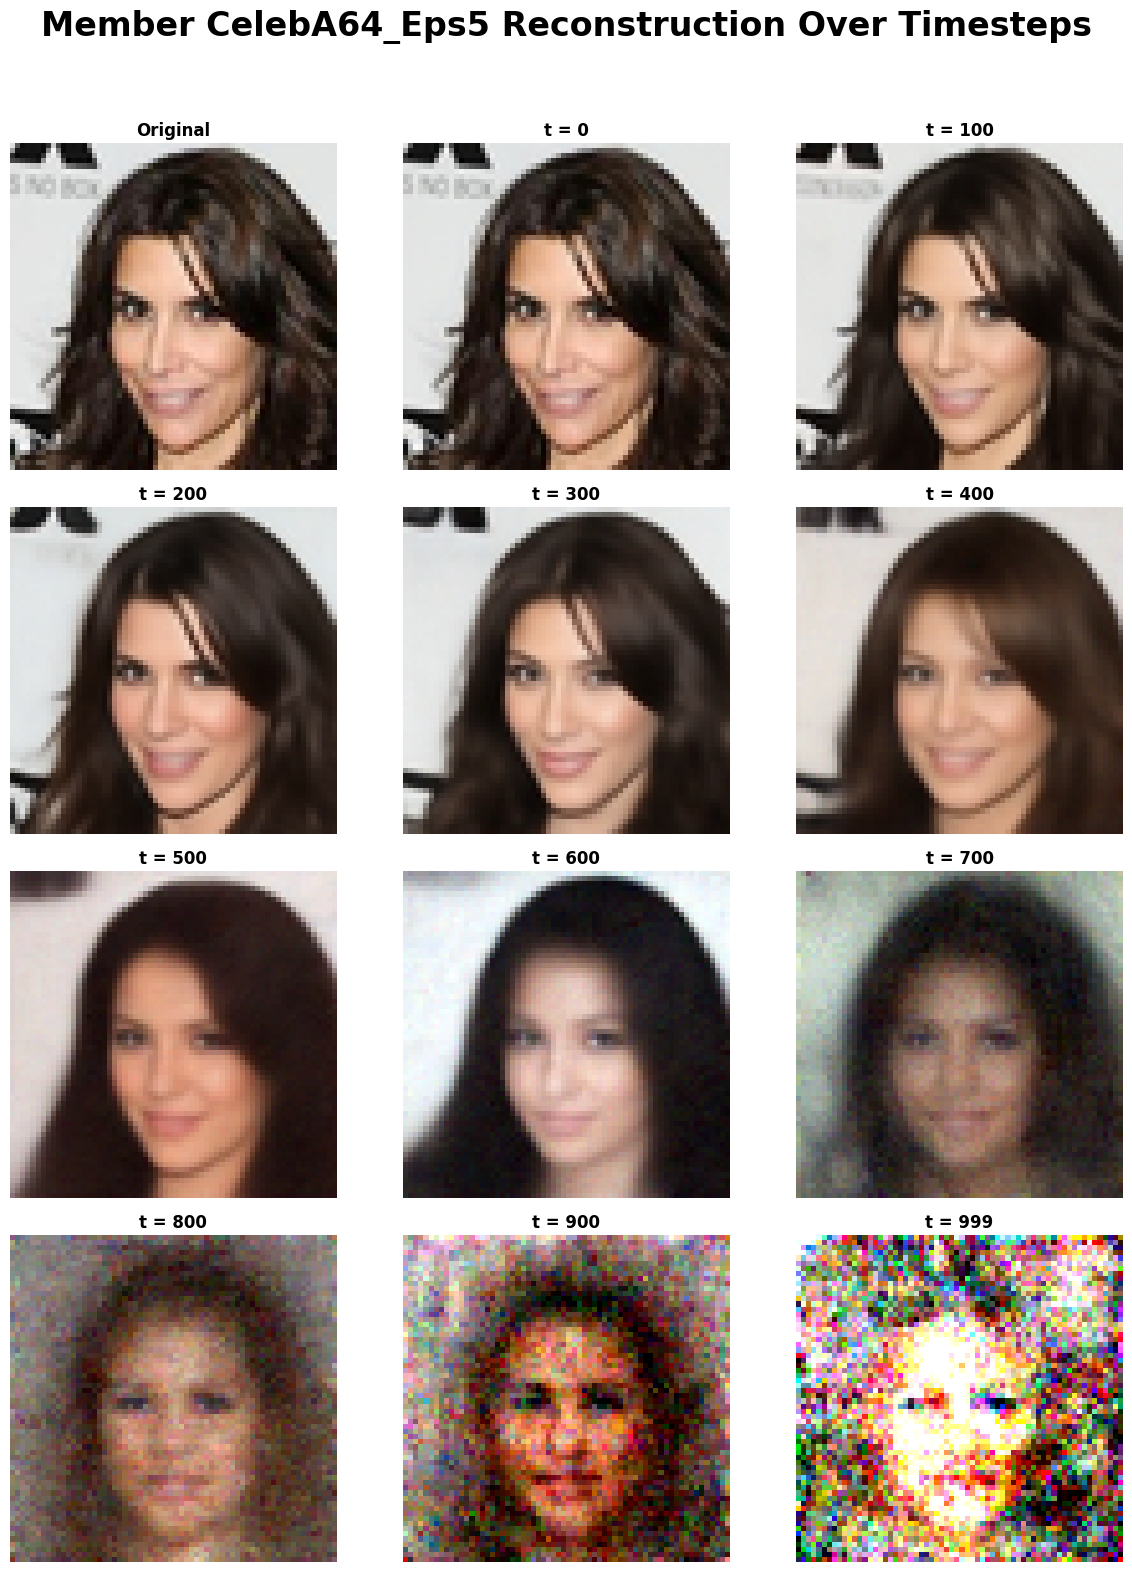


🖼️ Visualizing Non MEMBER sample


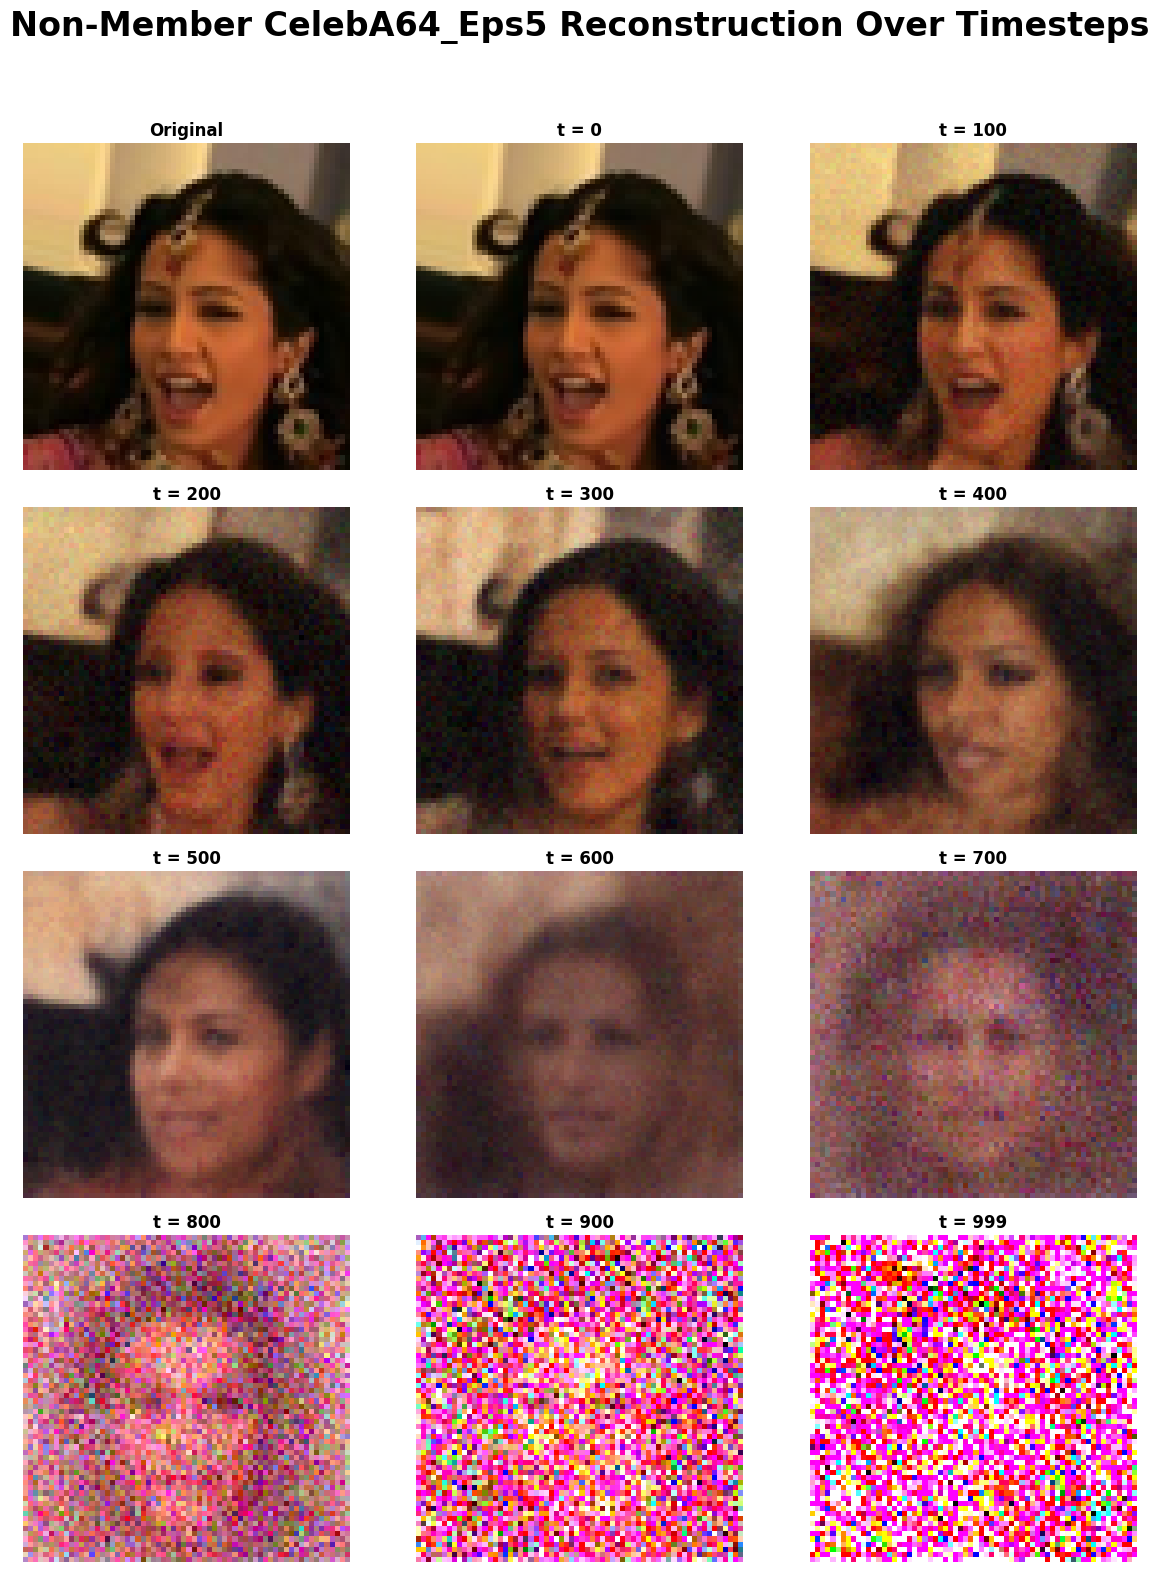

In [26]:
import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "CelebA64_Eps5"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA64_Eps5")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("CelebA64_Eps5_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("CelebA64_Eps5_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA64_Eps5", save_path="CelebA64_Eps5_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA64_Eps5", save_path="CelebA64_Eps5_Non_Member_Recon.png"
)

📡 Using device: cuda

📊 Dataset: Member
   Total images loaded: 162079
   First 5 image paths:
     - 061848.png
     - 009741.png
     - 055030.png
     - 115863.png
     - 046888.png

📊 Dataset: Non-Member
   Total images loaded: 40485
   First 5 image paths:
     - 168189.png
     - 165346.png
     - 188320.png
     - 168762.png
     - 176095.png

🚨 Remaining overlaps in Non-Member dataset: None


/tmp/ipykernel_594303/3535739233.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



⏱️ Evaluating timestep t = 0


🔄 Processing batches @ t=0: 100%|██████████| 1250/1250 [10:00<00:00,  2.08it/s]


📈 AUC @ t=0: 0.6389

⏱️ Evaluating timestep t = 100


🔄 Processing batches @ t=100: 100%|██████████| 1250/1250 [09:55<00:00,  2.10it/s]


📈 AUC @ t=100: 0.9060

⏱️ Evaluating timestep t = 200


🔄 Processing batches @ t=200: 100%|██████████| 1250/1250 [08:39<00:00,  2.41it/s]


📈 AUC @ t=200: 0.8409

⏱️ Evaluating timestep t = 300


🔄 Processing batches @ t=300: 100%|██████████| 1250/1250 [09:17<00:00,  2.24it/s]


📈 AUC @ t=300: 0.7226

⏱️ Evaluating timestep t = 400


🔄 Processing batches @ t=400: 100%|██████████| 1250/1250 [09:28<00:00,  2.20it/s]


📈 AUC @ t=400: 0.6426

⏱️ Evaluating timestep t = 500


🔄 Processing batches @ t=500: 100%|██████████| 1250/1250 [08:58<00:00,  2.32it/s]


📈 AUC @ t=500: 0.6120

⏱️ Evaluating timestep t = 600


🔄 Processing batches @ t=600: 100%|██████████| 1250/1250 [09:18<00:00,  2.24it/s]


📈 AUC @ t=600: 0.6156

⏱️ Evaluating timestep t = 700


🔄 Processing batches @ t=700: 100%|██████████| 1250/1250 [09:26<00:00,  2.21it/s]


📈 AUC @ t=700: 0.7126

⏱️ Evaluating timestep t = 800


🔄 Processing batches @ t=800: 100%|██████████| 1250/1250 [09:58<00:00,  2.09it/s]


📈 AUC @ t=800: 0.9309

⏱️ Evaluating timestep t = 900


🔄 Processing batches @ t=900: 100%|██████████| 1250/1250 [11:19<00:00,  1.84it/s]


📈 AUC @ t=900: 0.9997

⏱️ Evaluating timestep t = 999


🔄 Processing batches @ t=999: 100%|██████████| 1250/1250 [09:31<00:00,  2.19it/s]


📈 AUC @ t=999: 1.0000
✅ All timestep scores saved to 'WhiteBoxAttack.xlsx' in sheet 'CelebA64_Eps10'

📊 AUC Scores by Timestep:
               auc
timestep          
0         0.638932
100       0.906008
200       0.840916
300       0.722593
400       0.642633
500       0.612007
600       0.615588
700       0.712566
800       0.930892
900       0.999692
999       1.000000


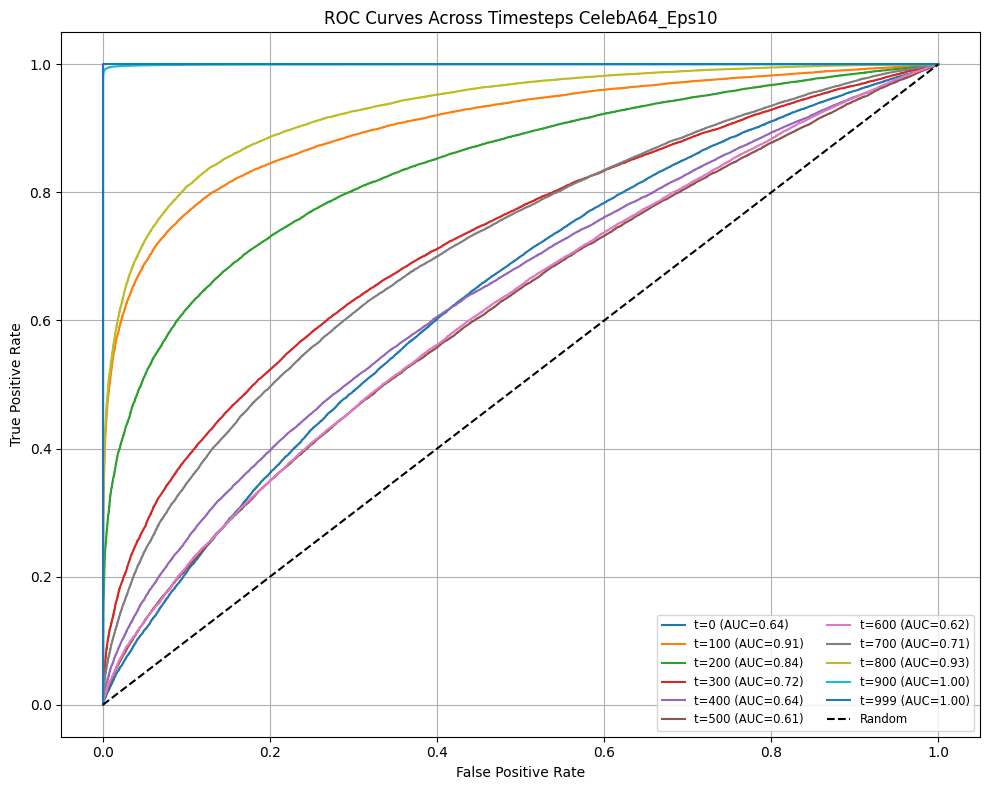

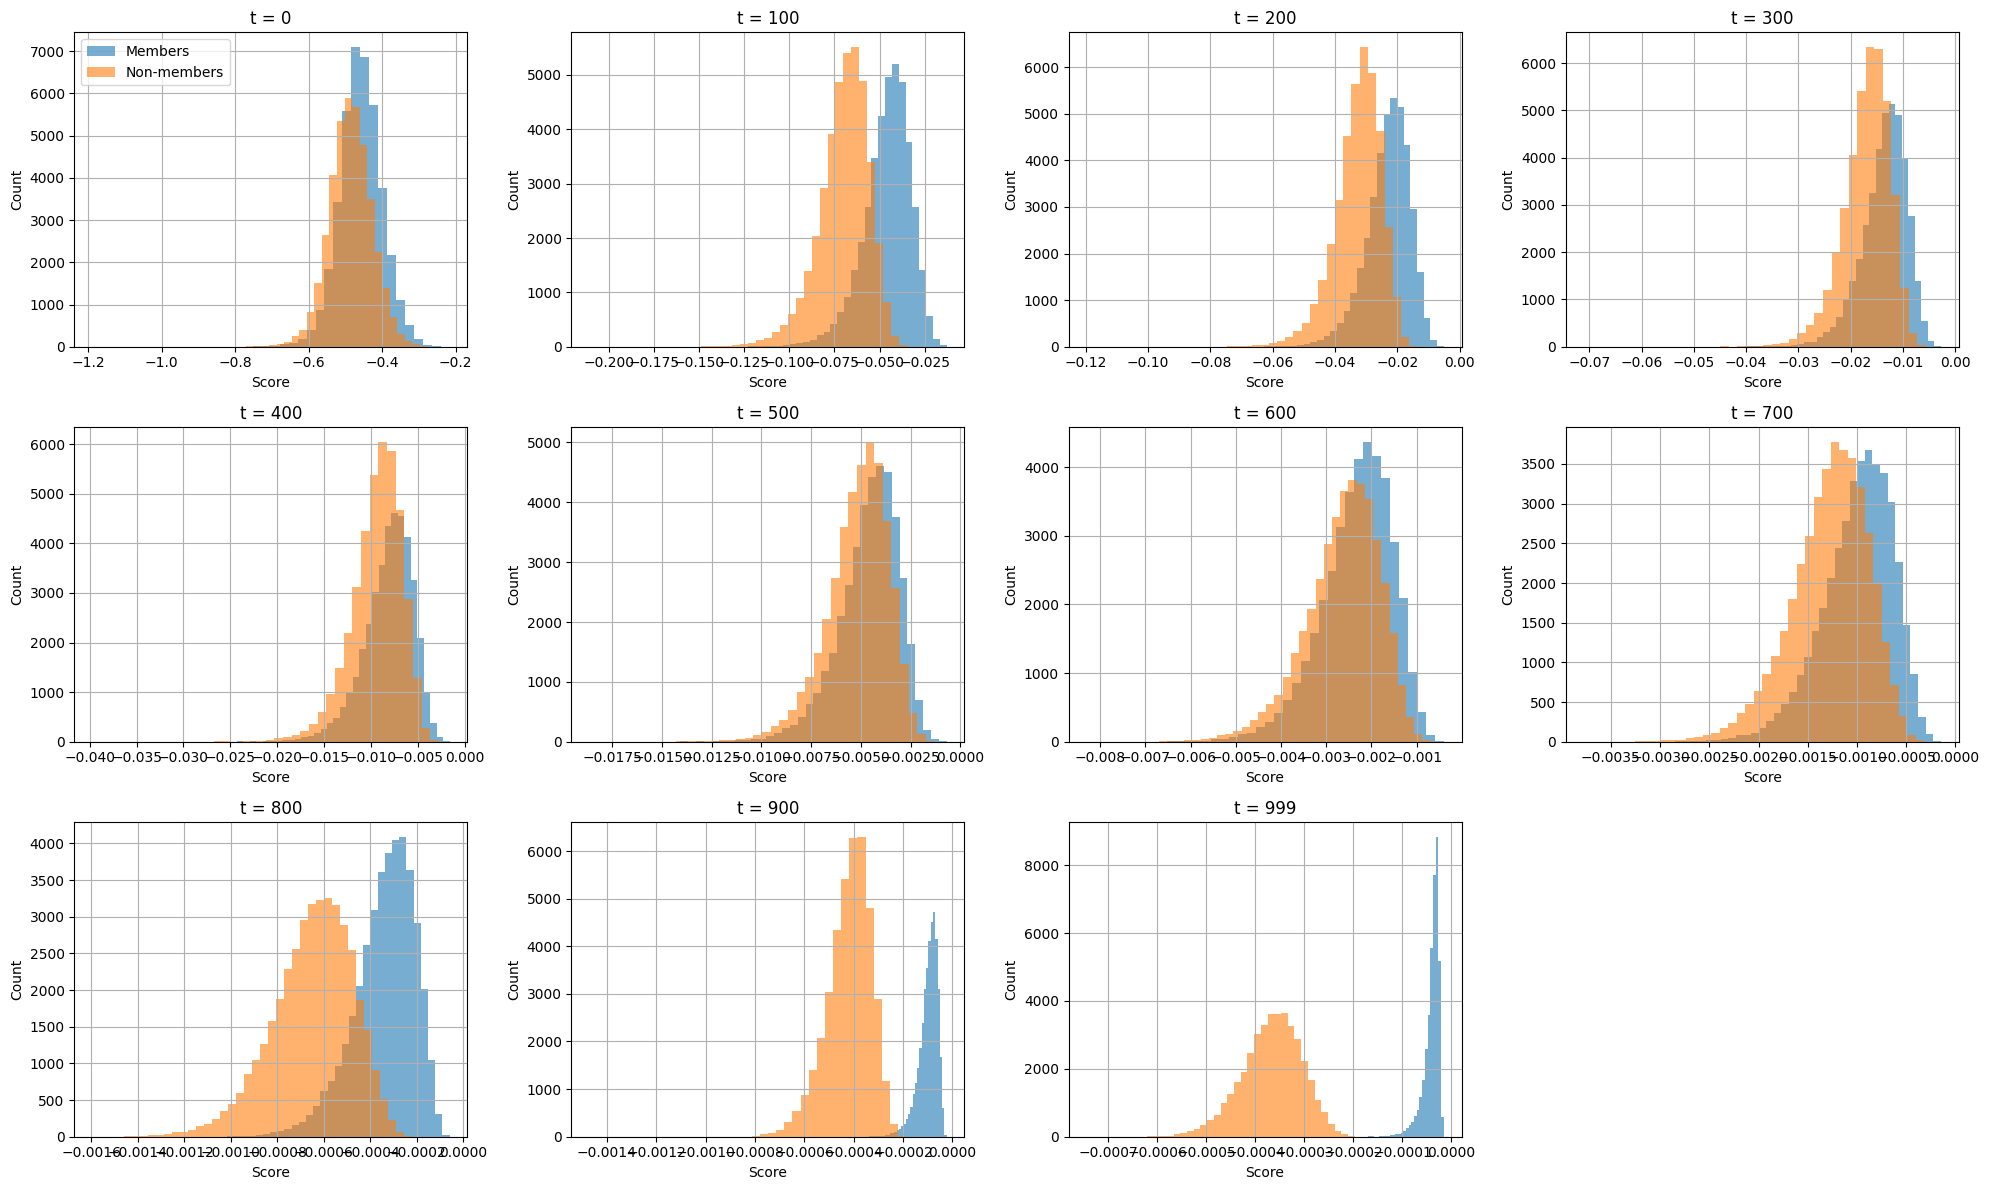


🖼️ Visualizing MEMBER sample


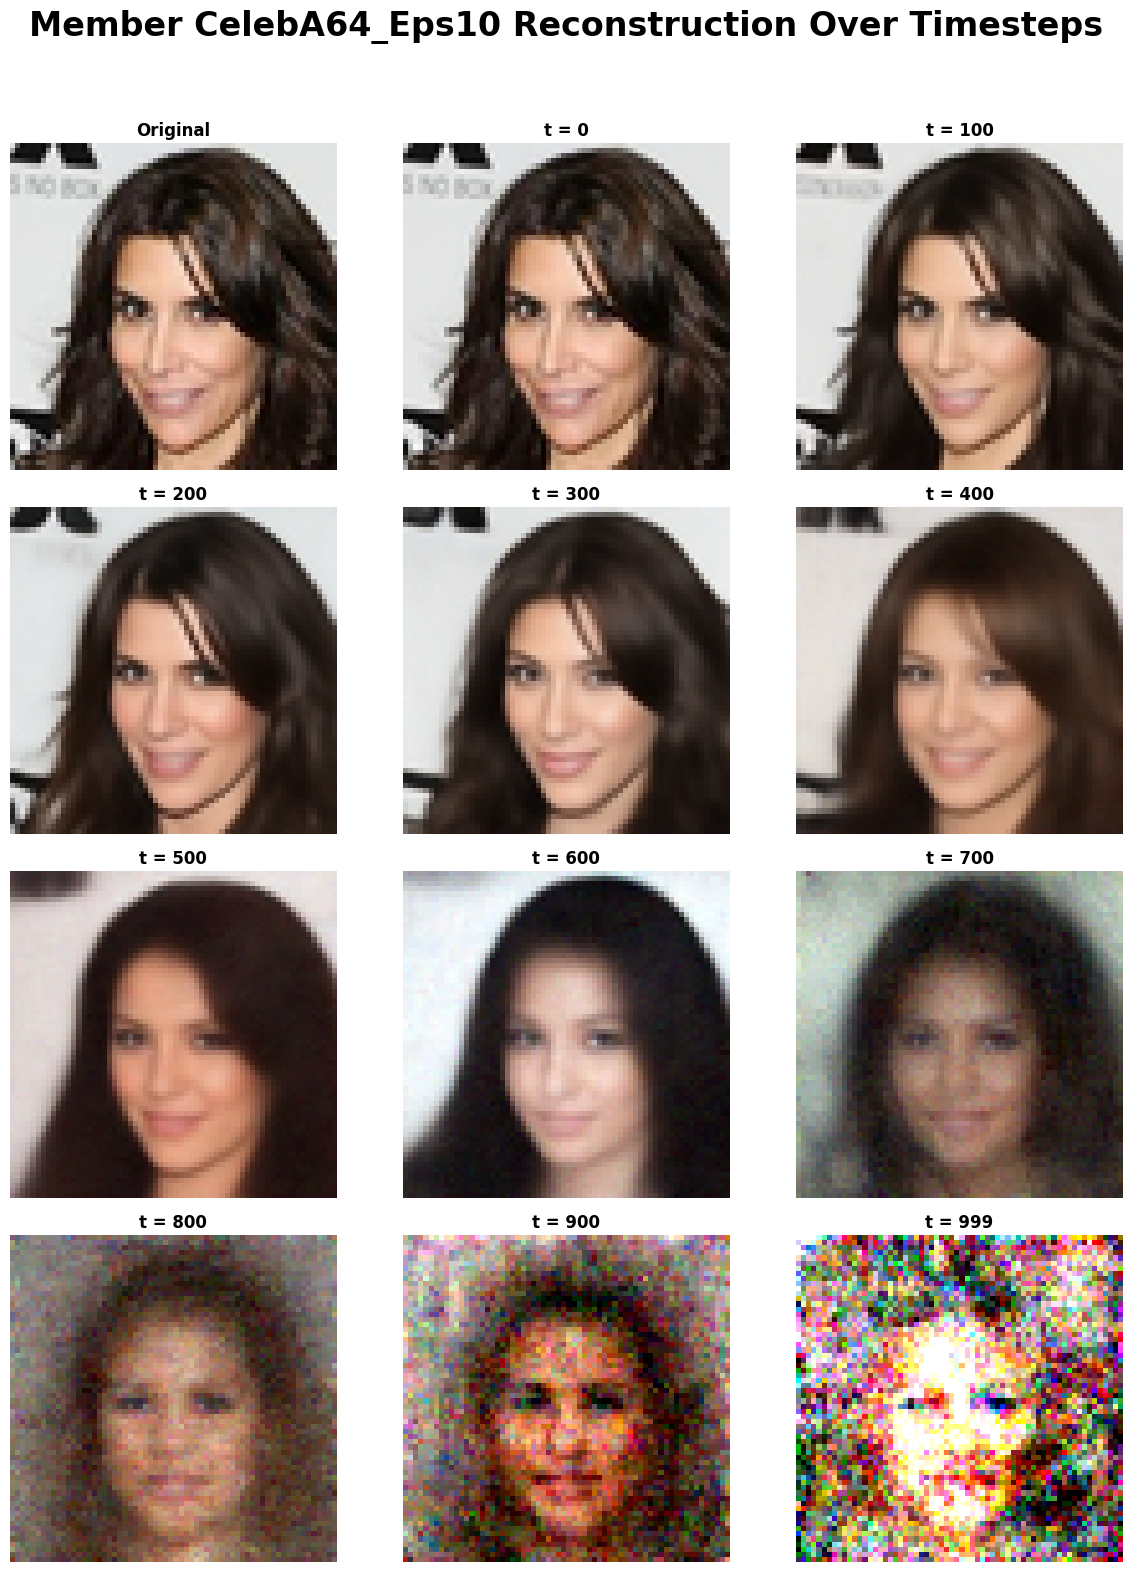


🖼️ Visualizing Non MEMBER sample


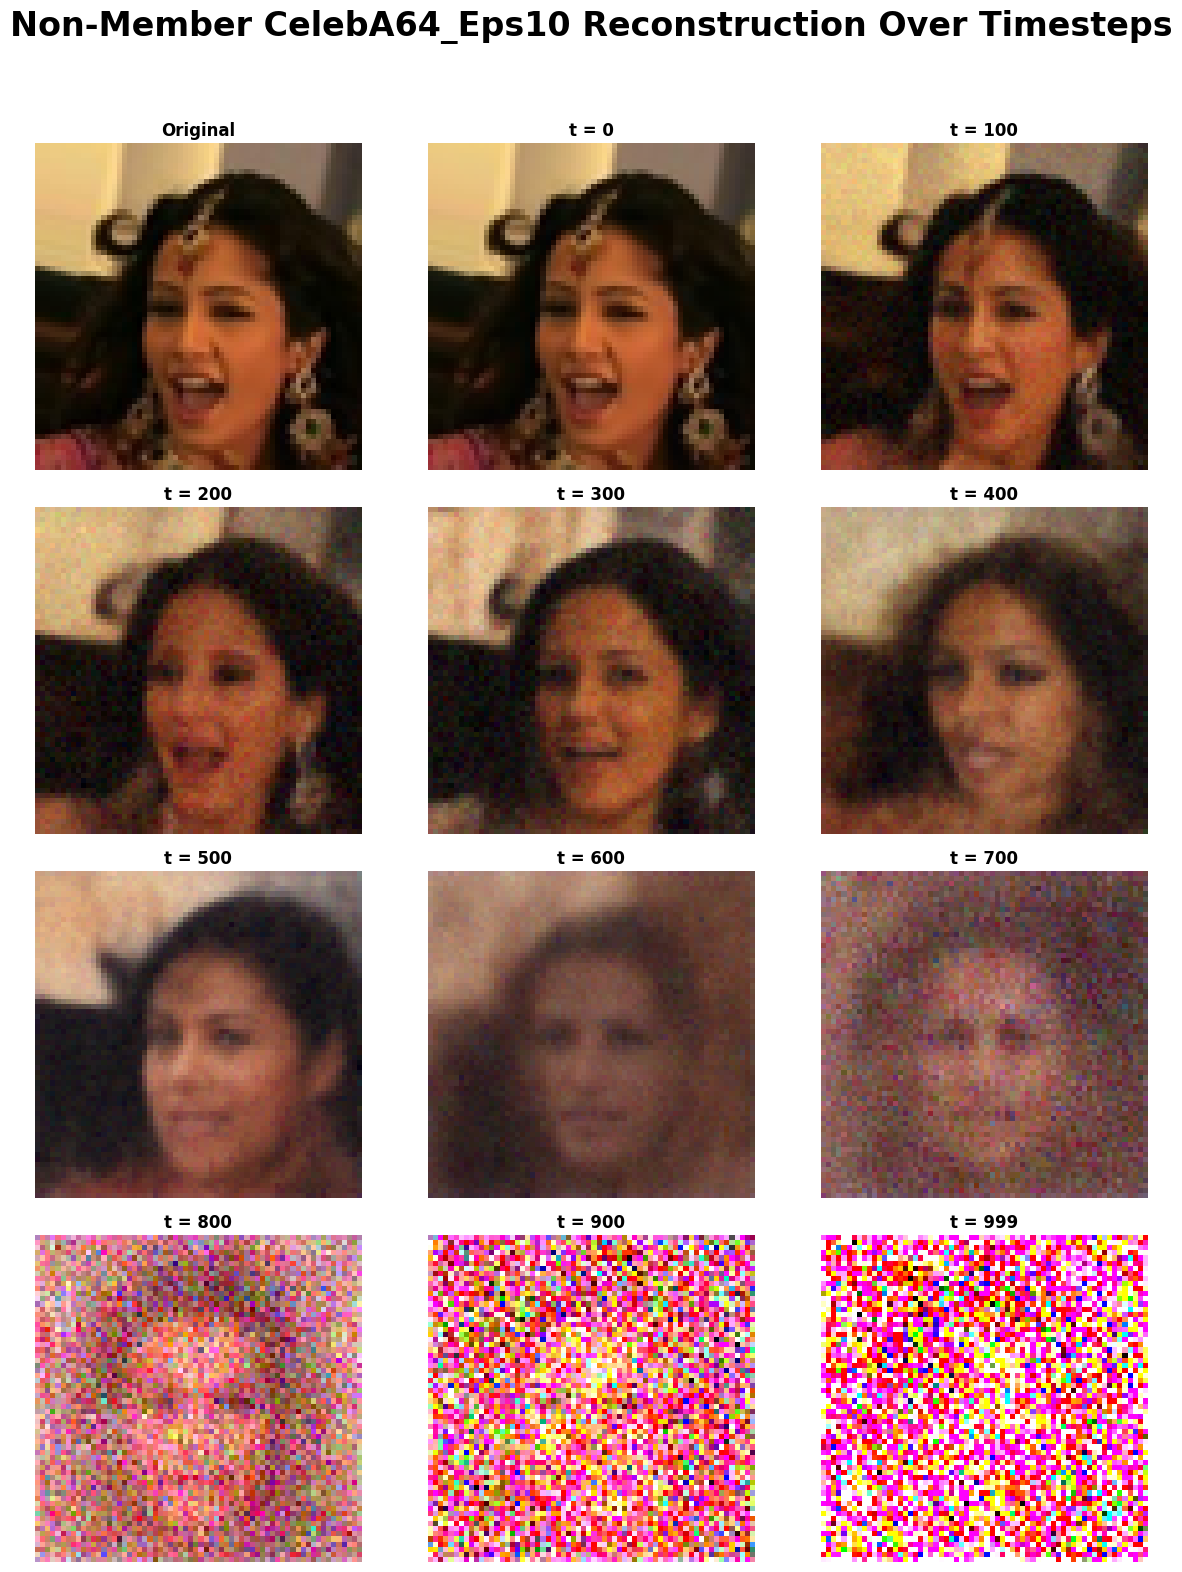

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import Subset
import numpy as np
from src.trainers import DPPromiseTrainer
import pandas as pd
import torch.nn.functional as F

# Now import custom modules
#from src.datasets import CustomImageDataset
from src.utils import get_unet_model, seed_everthing
from src.samplers import DDIMSampler

import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "CelebA64_Eps10"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

from PIL import Image

# --- Settings ---

member_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Train"
nonmember_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/64_Test"
config_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/configs/dp_promise/celeba_64/eps10.0/config.yaml"
ckpt_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba64_Eps10.0_celeba64_eps10.0_0809-20:46:35/checkpoints/ema_15.ckpt"

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📡 Using device: {device}")

# --- Config ---
config = OmegaConf.load(config_path)
seed_everthing(config.train.seed)

trainer = DPPromiseTrainer(config).to(device)

# --- Data Transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0, exclude_files=None):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label

        all_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Normalize exclude_files outside the if
        exclude_set = set(f.strip().lower() for f in exclude_files) if exclude_files else set()

        # Exclude files
        filtered_files = [f for f in all_files if f.strip().lower() not in exclude_set]

        self.image_paths = [os.path.join(image_dir, fname) for fname in filtered_files]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label


overlapping_nonmember_filenames = set([
    "165328.png" , "165694.png" , "166223.png" , "166493.png" , "166699.png" , "167671.png" , "168391.png" ,
    "168593.png" , "169496.png" , "170471.png" , "170604.png" , "170718.png" , "172963.png" , "173340.png" ,
    "175461.png" , "175527.png" , "176462.png" , "177540.png" , "177827.png" , "178379.png" , "179890.png" ,
    "180110.png" , "180455.png" , "180718.png" , "183407.png" , "183446.png" , "183954.png" , "186879.png" ,
    "187543.png" , "189148.png" , "194183.png" , "194529.png" , "195526.png" , "195916.png" , "197808.png" ])

# --- Load Datasets ---

nonmember_dataset = CustomImageDataset(nonmember_path, transform=transform, label=0, exclude_files= overlapping_nonmember_filenames)
member_dataset = CustomImageDataset(member_path, transform=transform, label=1)

# --- Dataset Stats & Sanity Check ---

def print_dataset_summary(dataset, name):
    print(f"\n📊 Dataset: {name}")
    print(f"   Total images loaded: {len(dataset)}")
    print(f"   First 5 image paths:")
    for path in dataset.image_paths[:5]:
        print(f"     - {os.path.basename(path)}")

print_dataset_summary(member_dataset, "Member")
print_dataset_summary(nonmember_dataset, "Non-Member")

# Double check: ensure no overlapping files in nonmember_dataset
nonmember_filenames = set(os.path.basename(p).lower().strip() for p in nonmember_dataset.image_paths)
remaining_overlap = nonmember_filenames & overlapping_nonmember_filenames
print(f"\n🚨 Remaining overlaps in Non-Member dataset: {remaining_overlap if remaining_overlap else 'None'}")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to use
sample_size = 40000

# Sample member indices
member_indices = np.random.choice(len(member_dataset), size=sample_size, replace=False)
balanced_member_dataset = Subset(member_dataset, member_indices)
member_loader = DataLoader(balanced_member_dataset, batch_size=32, shuffle=False)

# Sample non-member indices
nonmember_indices = np.random.choice(len(nonmember_dataset), size=sample_size, replace=False)
balanced_nonmember_dataset = Subset(nonmember_dataset, nonmember_indices)
nonmember_loader = DataLoader(balanced_nonmember_dataset, batch_size=32, shuffle=False)

#member_loader = DataLoader(member_dataset, batch_size=512, shuffle=False)
#nonmember_loader = DataLoader(nonmember_dataset, batch_size=512, shuffle=False)

# --- Load Model ---
model = get_unet_model(config).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"] if "state_dict" in ckpt else ckpt)
model.eval()

# --- Sampler ---
sampler = DDIMSampler(config)

import torch.nn.functional as F

def get_mia_scores_loss(images, labels, model, sampler, config, device, t_val):
    model.eval()
    scores = []
    batch_size = 64

    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(0, images.size(0), batch_size):
        img_batch = images[i:i+batch_size]
        lbl_batch = labels[i:i+batch_size]

        t = torch.full((img_batch.size(0),), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img_batch)
        noisy_img = trainer.q_sample(img_batch, t, noise)

        with torch.no_grad():
            preds = model(noisy_img, t, y=lbl_batch)

        loss = F.mse_loss(preds, noise, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        scores.extend((-loss).cpu().numpy())

    return scores

# --- Score Extraction ---

def get_all_scores(loader, t_val):
    all_scores = []
    all_labels = []
    for images, labels in tqdm(loader, desc=f"🔄 Processing batches @ t={t_val}"):
        scores = get_mia_scores_loss(images, labels, model, sampler, config, device, t_val)
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    return all_scores, all_labels

@torch.no_grad()
def predict_start_from_noise(x_t, t, noise, alphas_cumprod):
    alphas_cumprod = alphas_cumprod.to(x_t.device)

    # Clamp t to max-1 to avoid out-of-bounds access
    t_safe = torch.clamp(t, max=alphas_cumprod.shape[0] - 2)

    sqrt_alphas_cumprod = alphas_cumprod[t_safe + 1].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t_safe + 1]).sqrt().view(-1, 1, 1, 1)

    return (x_t - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod


def visualize_reconstruction(img, label, model, trainer, t_vals, alphas_cumprod, title_prefix="", save_path="Reconstruction.png"):
    model.eval()
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    num_plots = len(t_vals) + 1  # +1 for original
    num_rows = 4
    num_cols = math.ceil(num_plots / num_rows)  # calculate columns automatically

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axs = axs.flatten()  # flatten to simplify indexing

    # Original image
    axs[0].imshow(((img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
    axs[0].set_title("Original", fontweight='bold')
    axs[0].axis("off")

    # Reconstructions
    for i, t_val in enumerate(t_vals): 
        t = torch.full((1,), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img)
        noisy_img = trainer.q_sample(img, t, noise)

        with torch.no_grad():
            pred_noise = model(noisy_img, t, y=label)

        recon_img = predict_start_from_noise(noisy_img, t, pred_noise, alphas_cumprod)
        axs[i + 1].imshow(((recon_img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
        axs[i + 1].set_title(f"t = {t_val}", fontweight='bold')
        axs[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(num_plots, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"{title_prefix} Reconstruction Over Timesteps", fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() 

timesteps_to_eval = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
results = []
# Store all ROC curves for final combined plot
roc_curves = []  # each element will be (fpr, tpr, auc, timestep)
# For histogram subplots
histogram_data = []  # (timestep, member_scores, nonmember_scores)


for t_val in timesteps_to_eval:
    print(f"\n⏱️ Evaluating timestep t = {t_val}")

    member_scores, member_labels = get_all_scores(member_loader, t_val)
    nonmember_scores, nonmember_labels = get_all_scores(nonmember_loader, t_val)

    y_true = [1]*len(member_scores) + [0]*len(nonmember_scores)
    y_score = member_scores + nonmember_scores

    # Append to list for saving later
    timestep_df = pd.DataFrame({
        "timestep": [t_val] * len(y_true),
        "label": y_true,
        "score": y_score
    })
    all_timestep_data.append(timestep_df)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"📈 AUC @ t={t_val}: {auc:.4f}")
    results.append({"timestep": t_val, "auc": auc})
    roc_curves.append((fpr, tpr, auc, t_val))

    histogram_data.append((t_val, member_scores, nonmember_scores))

# After loop — save all timesteps in ONE worksheet
final_df = pd.concat(all_timestep_data, ignore_index=True)

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA64_Eps10")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("CelebA64_Eps10_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("CelebA64_Eps10_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA64_Eps10", save_path="CelebA64_Eps10_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA64_Eps10", save_path="CelebA64_Eps10_Non_Member_Recon.png"
)

## White Box Attack on Trained DP-Promise Model (CelebA 32 - eps 1, 5, & 10)

📡 Using device: cuda

📊 Dataset: Member
   Total images loaded: 162079
   First 5 image paths:
     - 061848.png
     - 009741.png
     - 055030.png
     - 115863.png
     - 046888.png

📊 Dataset: Non-Member
   Total images loaded: 40485
   First 5 image paths:
     - 168189.png
     - 165346.png
     - 188320.png
     - 168762.png
     - 176095.png

🚨 Remaining overlaps in Non-Member dataset: None


/tmp/ipykernel_594303/2718337962.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



⏱️ Evaluating timestep t = 0


🔄 Processing batches @ t=0: 100%|██████████| 1250/1250 [01:29<00:00, 13.96it/s]


📈 AUC @ t=0: 0.5855

⏱️ Evaluating timestep t = 100


🔄 Processing batches @ t=100: 100%|██████████| 1250/1250 [01:10<00:00, 17.72it/s]


📈 AUC @ t=100: 0.8772

⏱️ Evaluating timestep t = 200


🔄 Processing batches @ t=200: 100%|██████████| 1250/1250 [01:16<00:00, 16.24it/s]


📈 AUC @ t=200: 0.7659

⏱️ Evaluating timestep t = 300


🔄 Processing batches @ t=300: 100%|██████████| 1250/1250 [01:10<00:00, 17.80it/s]


📈 AUC @ t=300: 0.6448

⏱️ Evaluating timestep t = 400


🔄 Processing batches @ t=400: 100%|██████████| 1250/1250 [01:11<00:00, 17.42it/s]


📈 AUC @ t=400: 0.5790

⏱️ Evaluating timestep t = 500


🔄 Processing batches @ t=500: 100%|██████████| 1250/1250 [01:13<00:00, 16.96it/s]


📈 AUC @ t=500: 0.5584

⏱️ Evaluating timestep t = 600


🔄 Processing batches @ t=600: 100%|██████████| 1250/1250 [01:13<00:00, 17.08it/s]


📈 AUC @ t=600: 0.5852

⏱️ Evaluating timestep t = 700


🔄 Processing batches @ t=700: 100%|██████████| 1250/1250 [01:13<00:00, 16.95it/s]


📈 AUC @ t=700: 0.7064

⏱️ Evaluating timestep t = 800


🔄 Processing batches @ t=800: 100%|██████████| 1250/1250 [01:13<00:00, 16.95it/s]


📈 AUC @ t=800: 0.9003

⏱️ Evaluating timestep t = 900


🔄 Processing batches @ t=900: 100%|██████████| 1250/1250 [01:08<00:00, 18.37it/s]


📈 AUC @ t=900: 0.9927

⏱️ Evaluating timestep t = 999


🔄 Processing batches @ t=999: 100%|██████████| 1250/1250 [01:12<00:00, 17.33it/s]


📈 AUC @ t=999: 1.0000
✅ All timestep scores saved to 'WhiteBoxAttack.xlsx' in sheet 'CelebA32_Eps1'

📊 AUC Scores by Timestep:
               auc
timestep          
0         0.585520
100       0.877177
200       0.765856
300       0.644777
400       0.578999
500       0.558398
600       0.585172
700       0.706393
800       0.900256
900       0.992662
999       0.999963


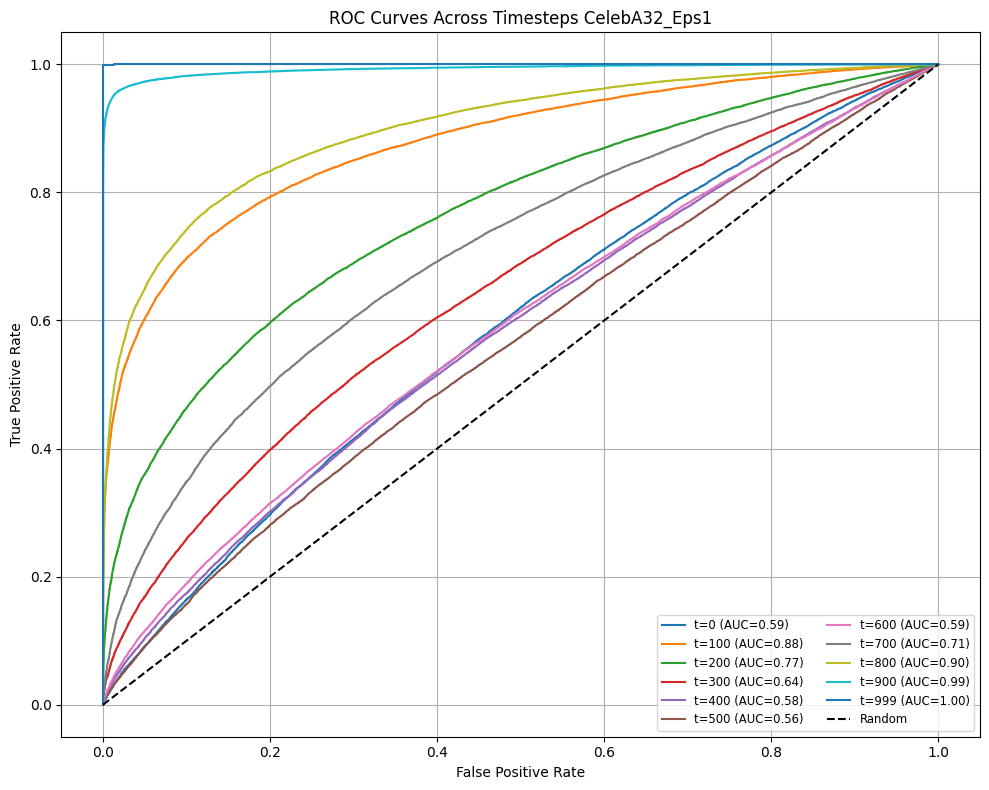

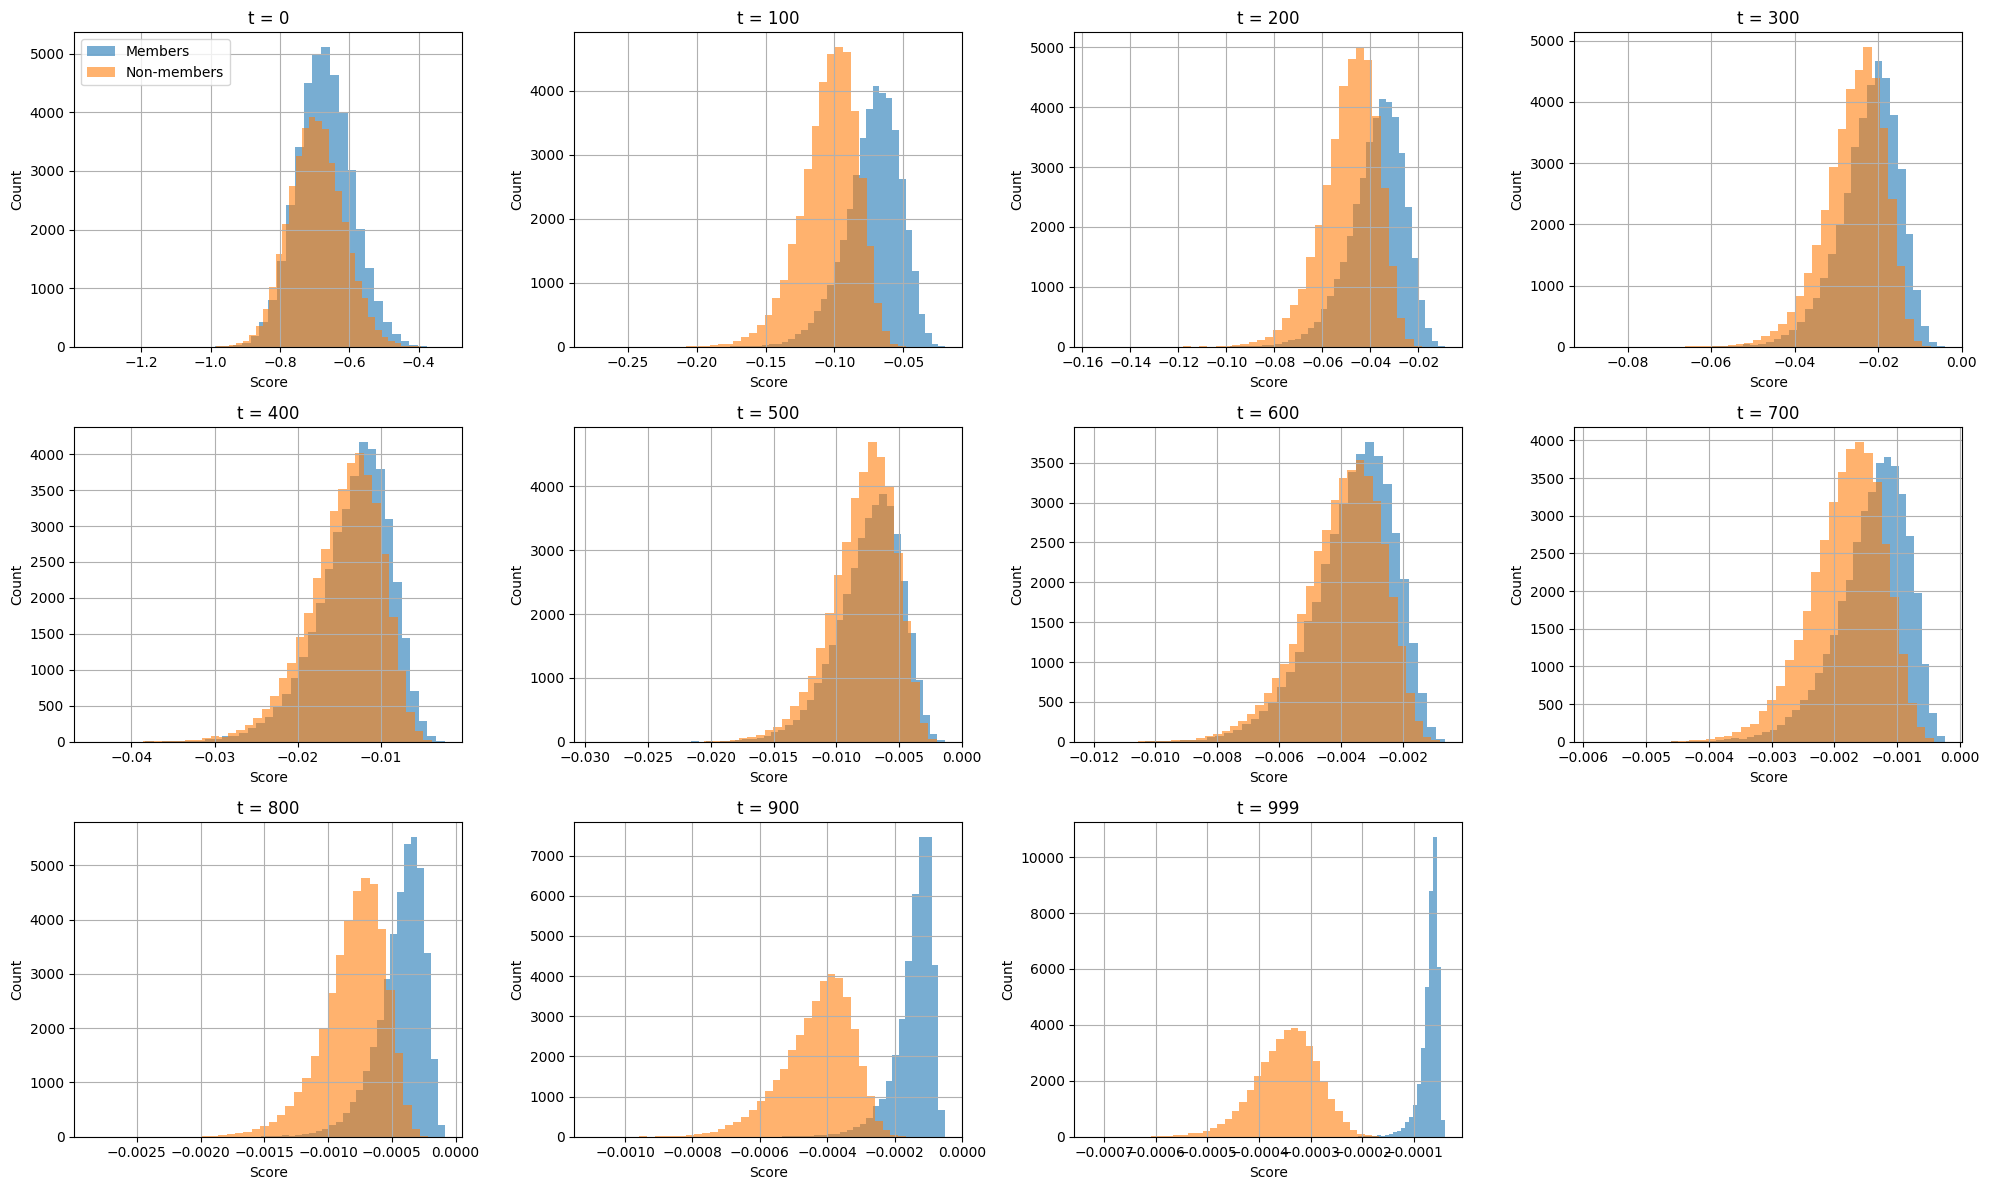


🖼️ Visualizing MEMBER sample


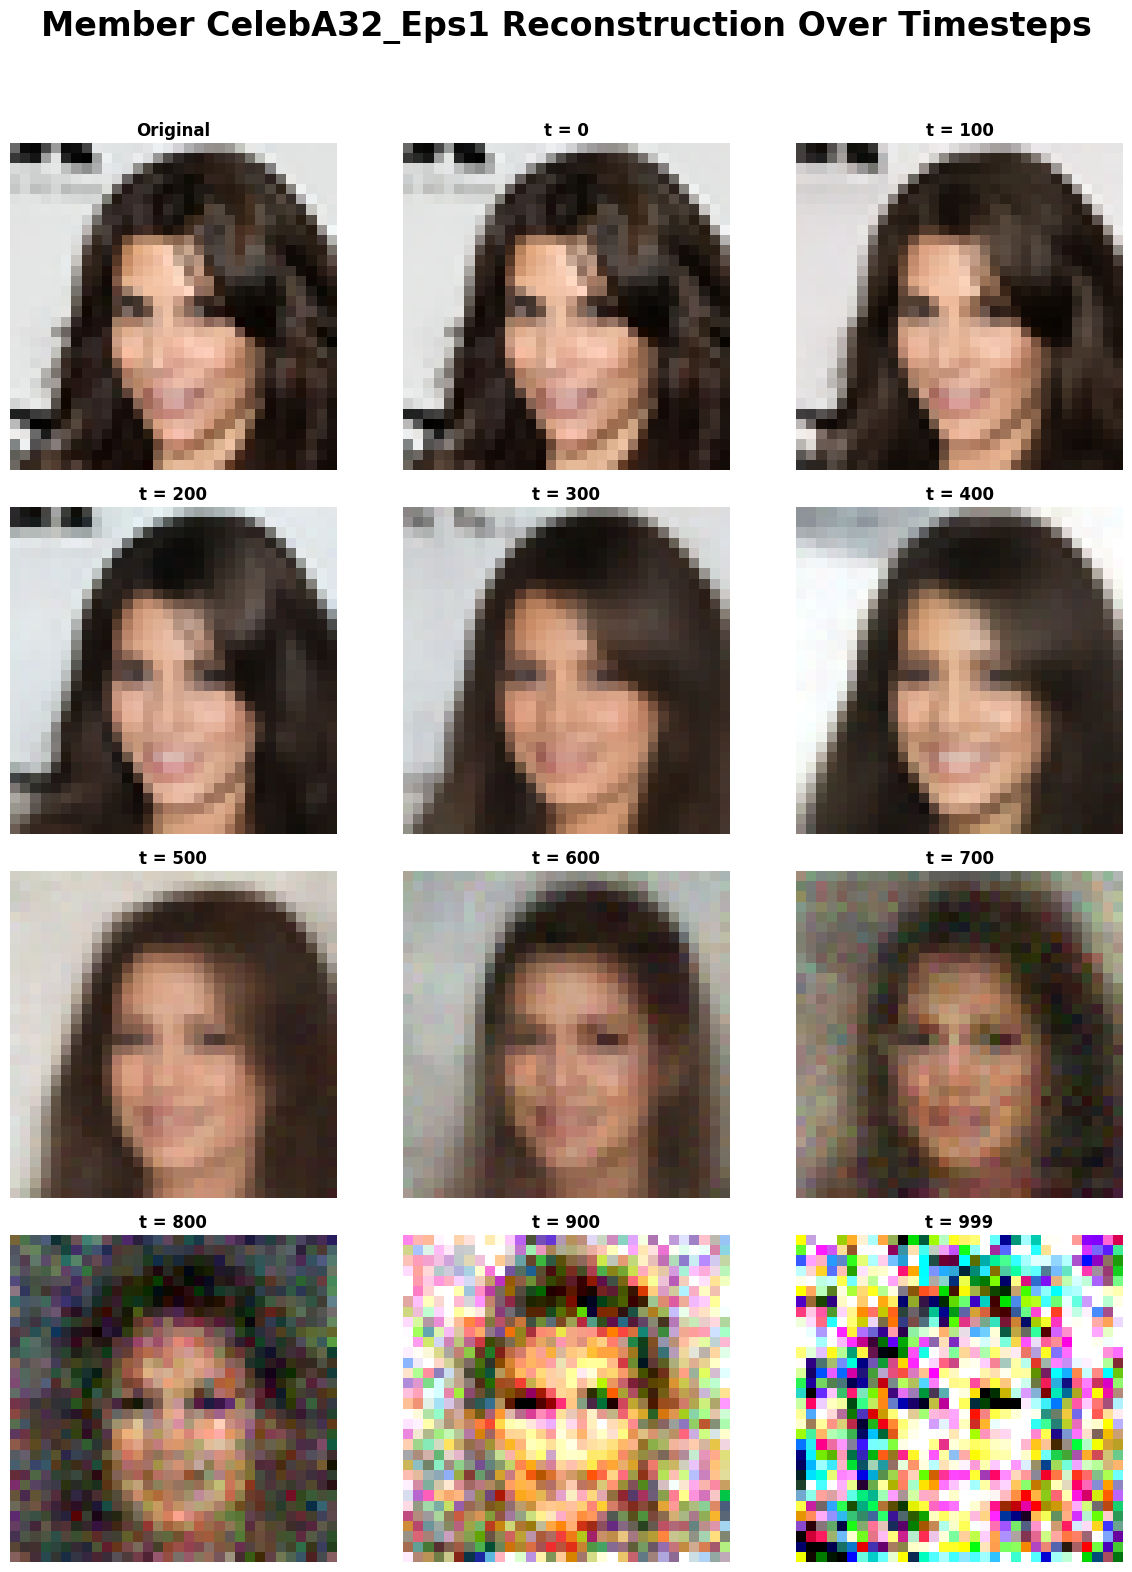


🖼️ Visualizing Non MEMBER sample


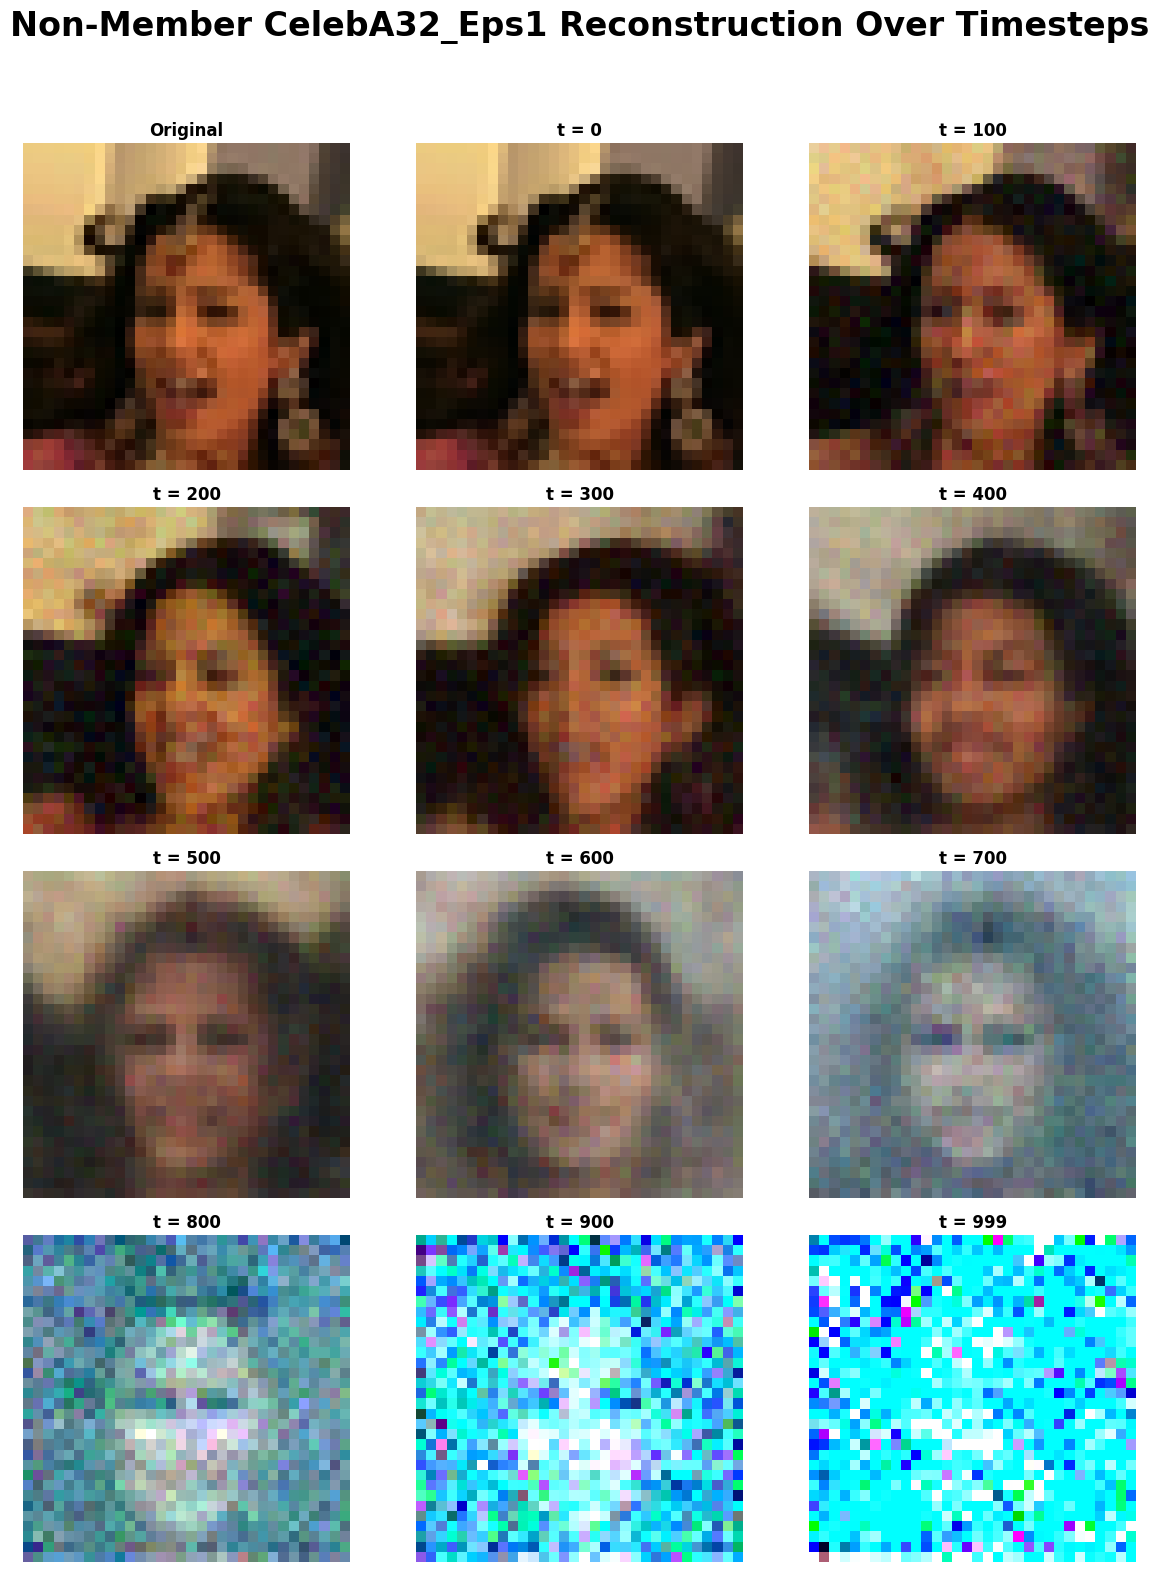

In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import Subset
import numpy as np
from src.trainers import DPPromiseTrainer
import pandas as pd
import torch.nn.functional as F

# Now import custom modules
#from src.datasets import CustomImageDataset
from src.utils import get_unet_model, seed_everthing
from src.samplers import DDIMSampler

import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "CelebA32_Eps1"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

from PIL import Image

# --- Settings ---

member_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
nonmember_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
config_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/configs/dp_promise/celeba_32/eps1.0/config.yaml"
ckpt_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps1.0_celeba_eps1.0_0725-07:04:43/checkpoints/ema_30.ckpt"

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📡 Using device: {device}")

# --- Config ---
config = OmegaConf.load(config_path)
seed_everthing(config.train.seed)

trainer = DPPromiseTrainer(config).to(device)

# --- Data Transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0, exclude_files=None):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label

        all_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Normalize exclude_files outside the if
        exclude_set = set(f.strip().lower() for f in exclude_files) if exclude_files else set()

        # Exclude files
        filtered_files = [f for f in all_files if f.strip().lower() not in exclude_set]

        self.image_paths = [os.path.join(image_dir, fname) for fname in filtered_files]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label


overlapping_nonmember_filenames = set([
    "165328.png" , "165694.png" , "166223.png" , "166493.png" , "166699.png" , "167671.png" , "168391.png" ,
    "168593.png" , "169496.png" , "170471.png" , "170604.png" , "170718.png" , "172963.png" , "173340.png" ,
    "175461.png" , "175527.png" , "176462.png" , "177540.png" , "177827.png" , "178379.png" , "179890.png" ,
    "180110.png" , "180455.png" , "180718.png" , "183407.png" , "183446.png" , "183954.png" , "186879.png" ,
    "187543.png" , "189148.png" , "194183.png" , "194529.png" , "195526.png" , "195916.png" , "197808.png" ])

# --- Load Datasets ---

nonmember_dataset = CustomImageDataset(nonmember_path, transform=transform, label=0, exclude_files= overlapping_nonmember_filenames)
member_dataset = CustomImageDataset(member_path, transform=transform, label=1)

# --- Dataset Stats & Sanity Check ---

def print_dataset_summary(dataset, name):
    print(f"\n📊 Dataset: {name}")
    print(f"   Total images loaded: {len(dataset)}")
    print(f"   First 5 image paths:")
    for path in dataset.image_paths[:5]:
        print(f"     - {os.path.basename(path)}")

print_dataset_summary(member_dataset, "Member")
print_dataset_summary(nonmember_dataset, "Non-Member")

# Double check: ensure no overlapping files in nonmember_dataset
nonmember_filenames = set(os.path.basename(p).lower().strip() for p in nonmember_dataset.image_paths)
remaining_overlap = nonmember_filenames & overlapping_nonmember_filenames
print(f"\n🚨 Remaining overlaps in Non-Member dataset: {remaining_overlap if remaining_overlap else 'None'}")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to use
sample_size = 40000

# Sample member indices
member_indices = np.random.choice(len(member_dataset), size=sample_size, replace=False)
balanced_member_dataset = Subset(member_dataset, member_indices)
member_loader = DataLoader(balanced_member_dataset, batch_size=32, shuffle=False)

# Sample non-member indices
nonmember_indices = np.random.choice(len(nonmember_dataset), size=sample_size, replace=False)
balanced_nonmember_dataset = Subset(nonmember_dataset, nonmember_indices)
nonmember_loader = DataLoader(balanced_nonmember_dataset, batch_size=32, shuffle=False)

#member_loader = DataLoader(member_dataset, batch_size=512, shuffle=False)
#nonmember_loader = DataLoader(nonmember_dataset, batch_size=512, shuffle=False)

# --- Load Model ---
model = get_unet_model(config).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"] if "state_dict" in ckpt else ckpt)
model.eval()

# --- Sampler ---
sampler = DDIMSampler(config)

import torch.nn.functional as F

def get_mia_scores_loss(images, labels, model, sampler, config, device, t_val):
    model.eval()
    scores = []
    batch_size = 64

    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(0, images.size(0), batch_size):
        img_batch = images[i:i+batch_size]
        lbl_batch = labels[i:i+batch_size]

        t = torch.full((img_batch.size(0),), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img_batch)
        noisy_img = trainer.q_sample(img_batch, t, noise)

        with torch.no_grad():
            preds = model(noisy_img, t, y=lbl_batch)

        loss = F.mse_loss(preds, noise, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        scores.extend((-loss).cpu().numpy())

    return scores

# --- Score Extraction ---

def get_all_scores(loader, t_val):
    all_scores = []
    all_labels = []
    for images, labels in tqdm(loader, desc=f"🔄 Processing batches @ t={t_val}"):
        scores = get_mia_scores_loss(images, labels, model, sampler, config, device, t_val)
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    return all_scores, all_labels

@torch.no_grad()
def predict_start_from_noise(x_t, t, noise, alphas_cumprod):
    alphas_cumprod = alphas_cumprod.to(x_t.device)

    # Clamp t to max-1 to avoid out-of-bounds access
    t_safe = torch.clamp(t, max=alphas_cumprod.shape[0] - 2)

    sqrt_alphas_cumprod = alphas_cumprod[t_safe + 1].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t_safe + 1]).sqrt().view(-1, 1, 1, 1)

    return (x_t - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod


def visualize_reconstruction(img, label, model, trainer, t_vals, alphas_cumprod, title_prefix="", save_path="Reconstruction.png"):
    model.eval()
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    num_plots = len(t_vals) + 1  # +1 for original
    num_rows = 4
    num_cols = math.ceil(num_plots / num_rows)  # calculate columns automatically

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axs = axs.flatten()  # flatten to simplify indexing

    # Original image
    axs[0].imshow(((img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
    axs[0].set_title("Original", fontweight='bold')
    axs[0].axis("off")

    # Reconstructions
    for i, t_val in enumerate(t_vals): 
        t = torch.full((1,), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img)
        noisy_img = trainer.q_sample(img, t, noise)

        with torch.no_grad():
            pred_noise = model(noisy_img, t, y=label)

        recon_img = predict_start_from_noise(noisy_img, t, pred_noise, alphas_cumprod)
        axs[i + 1].imshow(((recon_img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
        axs[i + 1].set_title(f"t = {t_val}", fontweight='bold')
        axs[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(num_plots, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"{title_prefix} Reconstruction Over Timesteps", fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() 

timesteps_to_eval = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
results = []
# Store all ROC curves for final combined plot
roc_curves = []  # each element will be (fpr, tpr, auc, timestep)
# For histogram subplots
histogram_data = []  # (timestep, member_scores, nonmember_scores)


for t_val in timesteps_to_eval:
    print(f"\n⏱️ Evaluating timestep t = {t_val}")

    member_scores, member_labels = get_all_scores(member_loader, t_val)
    nonmember_scores, nonmember_labels = get_all_scores(nonmember_loader, t_val)

    y_true = [1]*len(member_scores) + [0]*len(nonmember_scores)
    y_score = member_scores + nonmember_scores

    # Append to list for saving later
    timestep_df = pd.DataFrame({
        "timestep": [t_val] * len(y_true),
        "label": y_true,
        "score": y_score
    })
    all_timestep_data.append(timestep_df)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"📈 AUC @ t={t_val}: {auc:.4f}")
    results.append({"timestep": t_val, "auc": auc})
    roc_curves.append((fpr, tpr, auc, t_val))

    histogram_data.append((t_val, member_scores, nonmember_scores))

# After loop — save all timesteps in ONE worksheet
final_df = pd.concat(all_timestep_data, ignore_index=True)

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA32_Eps1")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("CelebA32_Eps1_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("CelebA32_Eps1_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA32_Eps1", save_path="CelebA32_Eps1_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA32_Eps1", save_path="CelebA32_Eps1_Non_Member_Recon.png"
)

📡 Using device: cuda

📊 Dataset: Member
   Total images loaded: 162079
   First 5 image paths:
     - 061848.png
     - 009741.png
     - 055030.png
     - 115863.png
     - 046888.png

📊 Dataset: Non-Member
   Total images loaded: 40485
   First 5 image paths:
     - 168189.png
     - 165346.png
     - 188320.png
     - 168762.png
     - 176095.png

🚨 Remaining overlaps in Non-Member dataset: None


/tmp/ipykernel_3047596/345834195.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



⏱️ Evaluating timestep t = 0


🔄 Processing batches @ t=0: 100%|██████████| 1250/1250 [03:50<00:00,  5.41it/s]


📈 AUC @ t=0: 0.5727

⏱️ Evaluating timestep t = 100


🔄 Processing batches @ t=100: 100%|██████████| 1250/1250 [01:10<00:00, 17.72it/s]


📈 AUC @ t=100: 0.8745

⏱️ Evaluating timestep t = 200


🔄 Processing batches @ t=200: 100%|██████████| 1250/1250 [01:16<00:00, 16.24it/s]


📈 AUC @ t=200: 0.7768

⏱️ Evaluating timestep t = 300


🔄 Processing batches @ t=300: 100%|██████████| 1250/1250 [01:10<00:00, 17.80it/s]


📈 AUC @ t=300: 0.6606

⏱️ Evaluating timestep t = 400


🔄 Processing batches @ t=400: 100%|██████████| 1250/1250 [01:11<00:00, 17.42it/s]


📈 AUC @ t=400: 0.5915

⏱️ Evaluating timestep t = 500


🔄 Processing batches @ t=500: 100%|██████████| 1250/1250 [01:13<00:00, 16.96it/s]


📈 AUC @ t=500: 0.5699

⏱️ Evaluating timestep t = 600


🔄 Processing batches @ t=600: 100%|██████████| 1250/1250 [01:13<00:00, 17.08it/s]


📈 AUC @ t=600: 0.5941

⏱️ Evaluating timestep t = 700


🔄 Processing batches @ t=700: 100%|██████████| 1250/1250 [01:13<00:00, 16.95it/s]


📈 AUC @ t=700: 0.7106

⏱️ Evaluating timestep t = 800


🔄 Processing batches @ t=800: 100%|██████████| 1250/1250 [01:13<00:00, 16.95it/s]


📈 AUC @ t=800: 0.9080

⏱️ Evaluating timestep t = 900


🔄 Processing batches @ t=900: 100%|██████████| 1250/1250 [01:08<00:00, 18.37it/s]


📈 AUC @ t=900: 0.9987

⏱️ Evaluating timestep t = 999


🔄 Processing batches @ t=999: 100%|██████████| 1250/1250 [01:12<00:00, 17.33it/s]


📈 AUC @ t=999: 1.0000
✅ All timestep scores saved to 'WhiteBoxAttack.xlsx' in sheet 'CelebA32_Eps5'

📊 AUC Scores by Timestep:
               auc
timestep          
0         0.572704
100       0.874520
200       0.776786
300       0.660641
400       0.591531
500       0.569890
600       0.594052
700       0.710567
800       0.907990
900       0.998665
999       1.000000


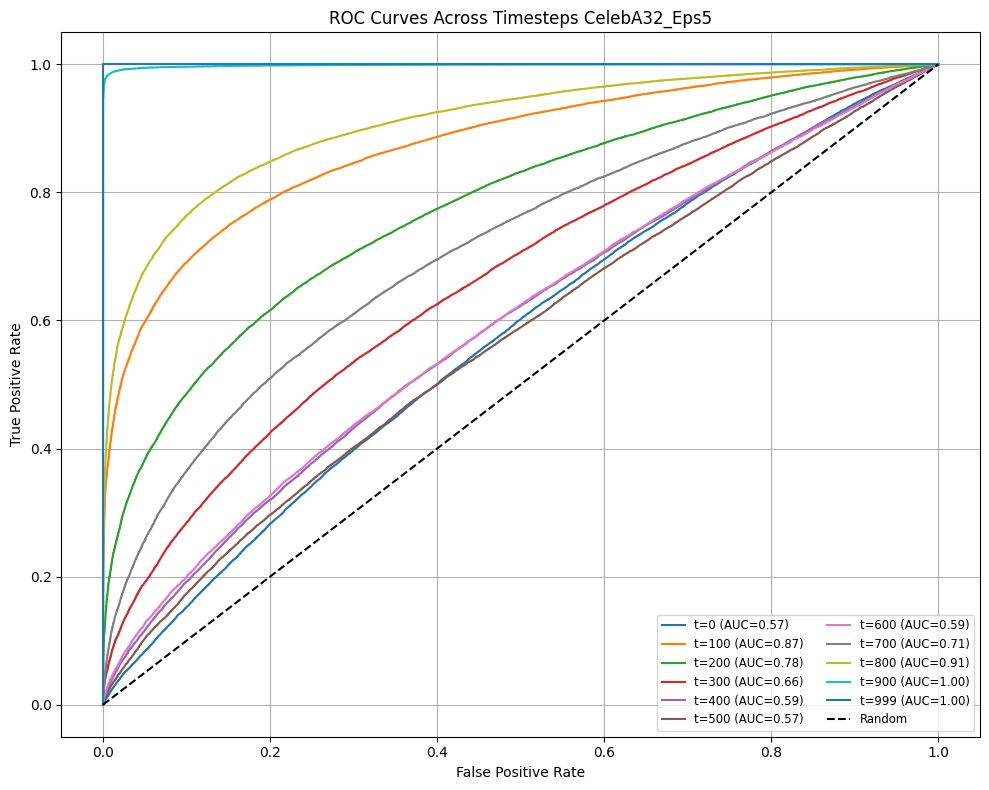

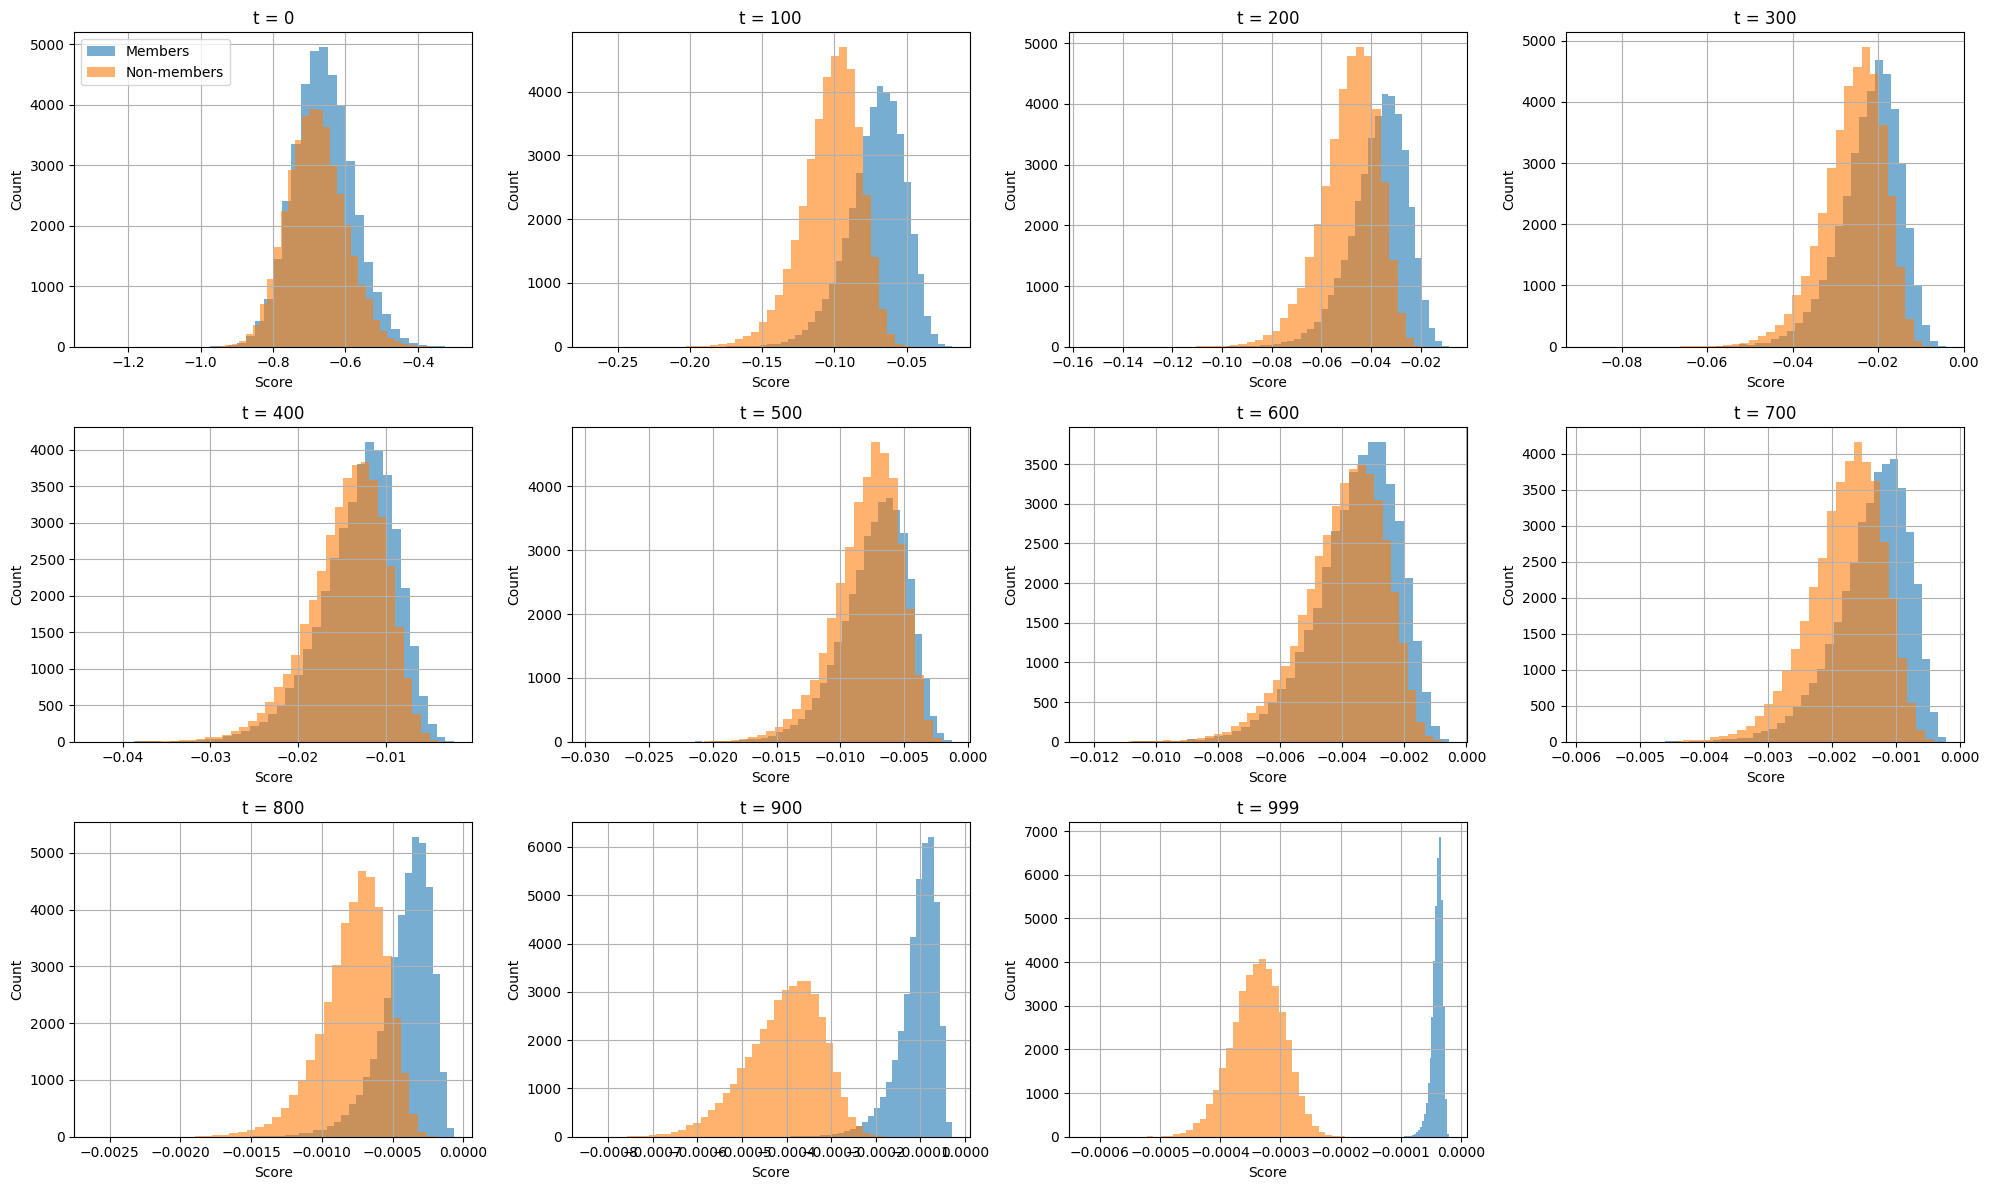


🖼️ Visualizing MEMBER sample


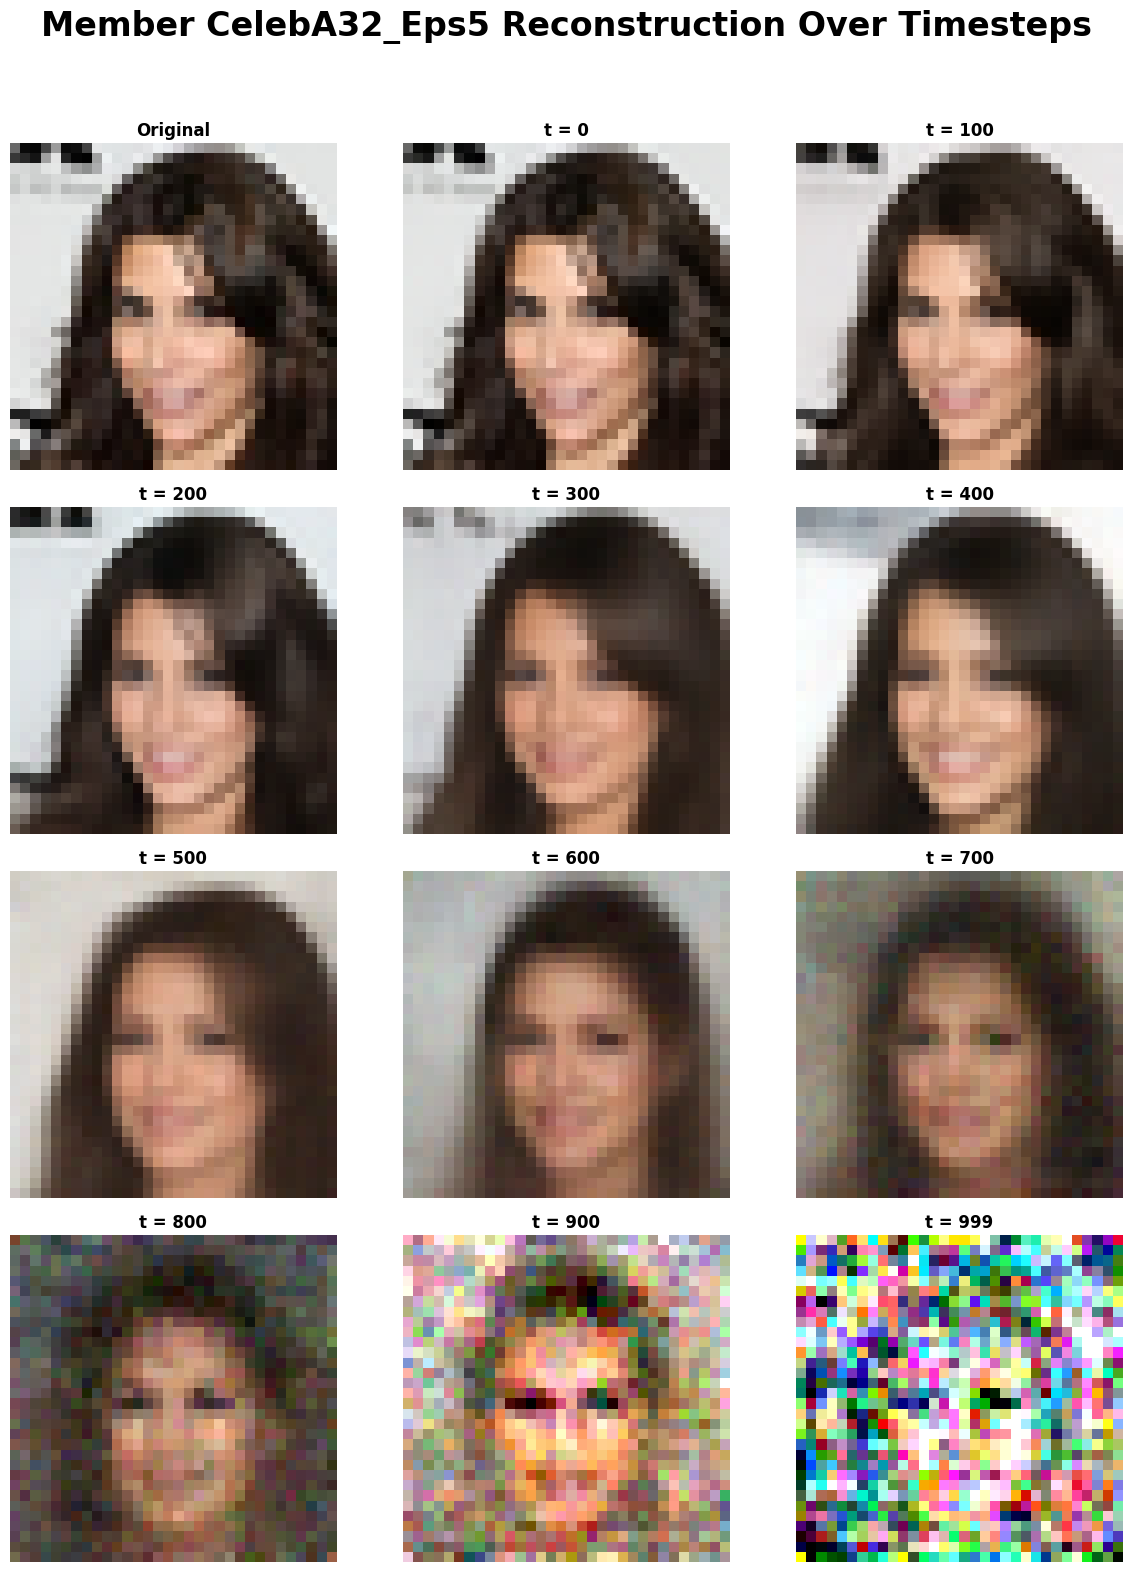


🖼️ Visualizing Non MEMBER sample


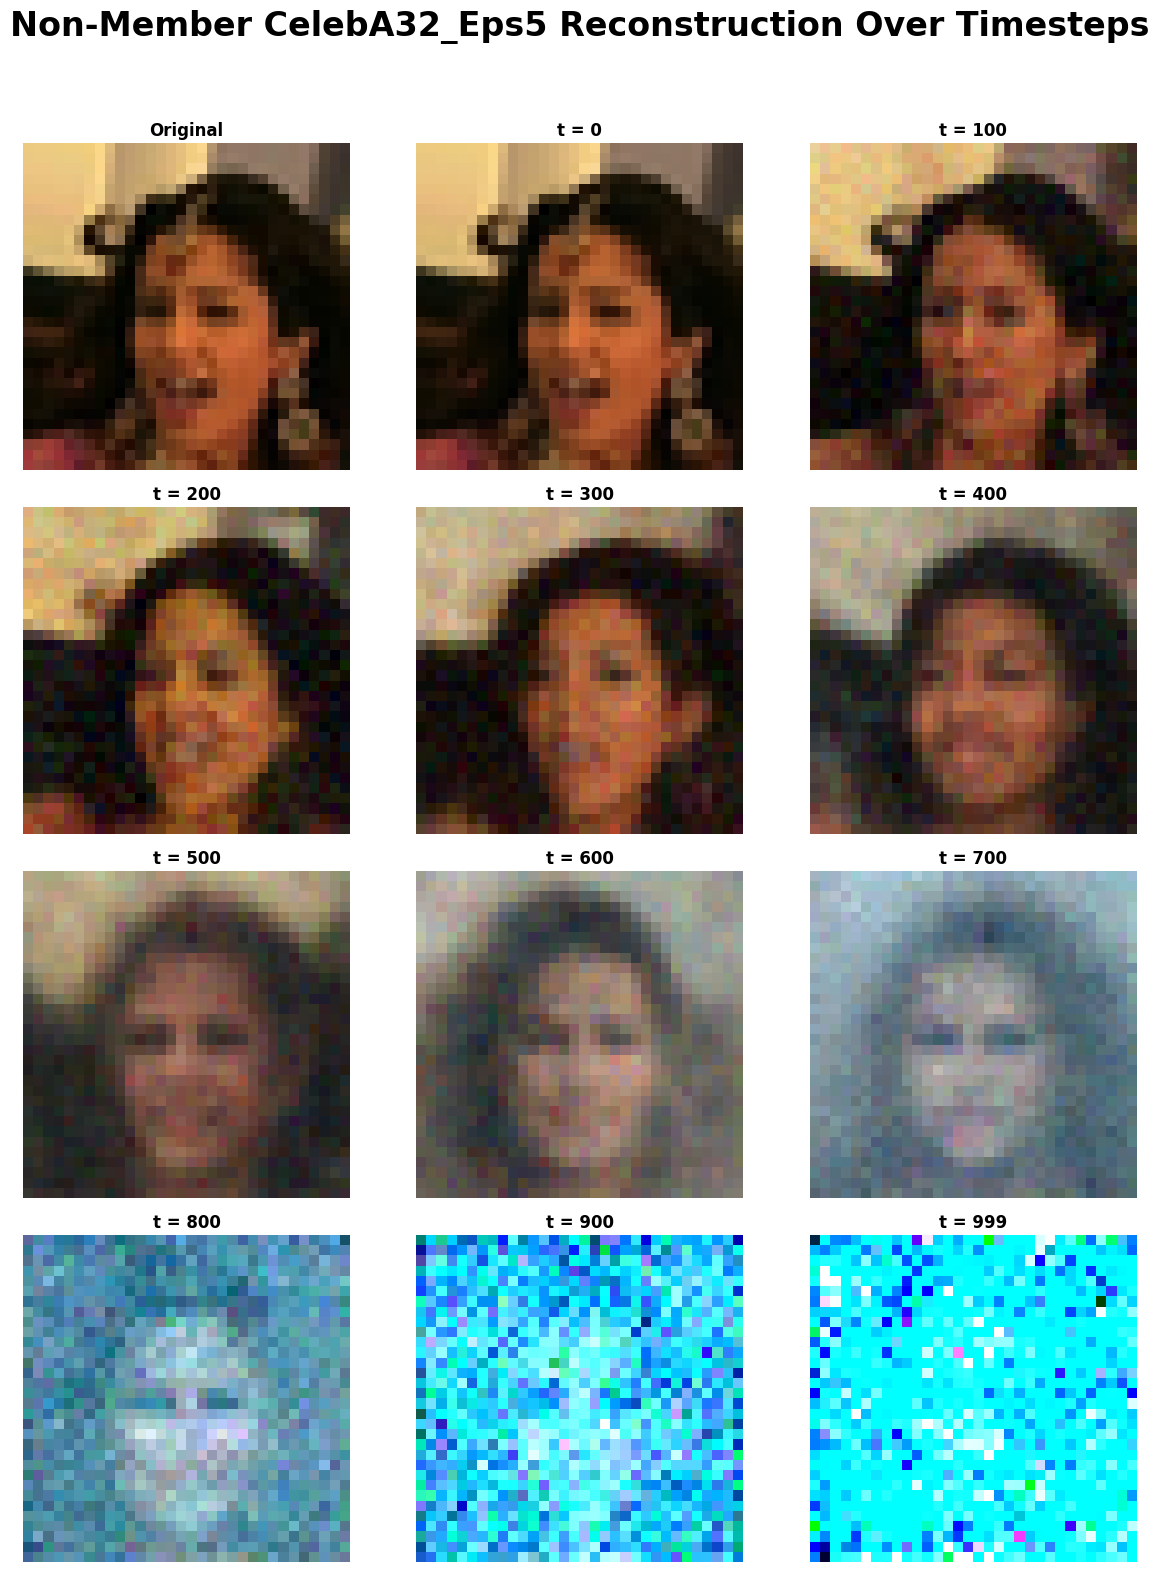

In [28]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import Subset
import numpy as np
from src.trainers import DPPromiseTrainer
import pandas as pd
import torch.nn.functional as F

# Now import custom modules
#from src.datasets import CustomImageDataset
from src.utils import get_unet_model, seed_everthing
from src.samplers import DDIMSampler

import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "CelebA32_Eps5"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

from PIL import Image

# --- Settings ---

member_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
nonmember_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
config_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/configs/dp_promise/celeba_32/eps5.0/config.yaml"
ckpt_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps5.0_celeba_eps5.0_0726-22:50:56/checkpoints/ema_30.ckpt"

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📡 Using device: {device}")

# --- Config ---
config = OmegaConf.load(config_path)
seed_everthing(config.train.seed)

trainer = DPPromiseTrainer(config).to(device)

# --- Data Transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0, exclude_files=None):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label

        all_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Normalize exclude_files outside the if
        exclude_set = set(f.strip().lower() for f in exclude_files) if exclude_files else set()

        # Exclude files
        filtered_files = [f for f in all_files if f.strip().lower() not in exclude_set]

        self.image_paths = [os.path.join(image_dir, fname) for fname in filtered_files]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label


overlapping_nonmember_filenames = set([
    "165328.png" , "165694.png" , "166223.png" , "166493.png" , "166699.png" , "167671.png" , "168391.png" ,
    "168593.png" , "169496.png" , "170471.png" , "170604.png" , "170718.png" , "172963.png" , "173340.png" ,
    "175461.png" , "175527.png" , "176462.png" , "177540.png" , "177827.png" , "178379.png" , "179890.png" ,
    "180110.png" , "180455.png" , "180718.png" , "183407.png" , "183446.png" , "183954.png" , "186879.png" ,
    "187543.png" , "189148.png" , "194183.png" , "194529.png" , "195526.png" , "195916.png" , "197808.png" ])

# --- Load Datasets ---

nonmember_dataset = CustomImageDataset(nonmember_path, transform=transform, label=0, exclude_files= overlapping_nonmember_filenames)
member_dataset = CustomImageDataset(member_path, transform=transform, label=1)

# --- Dataset Stats & Sanity Check ---

def print_dataset_summary(dataset, name):
    print(f"\n📊 Dataset: {name}")
    print(f"   Total images loaded: {len(dataset)}")
    print(f"   First 5 image paths:")
    for path in dataset.image_paths[:5]:
        print(f"     - {os.path.basename(path)}")

print_dataset_summary(member_dataset, "Member")
print_dataset_summary(nonmember_dataset, "Non-Member")

# Double check: ensure no overlapping files in nonmember_dataset
nonmember_filenames = set(os.path.basename(p).lower().strip() for p in nonmember_dataset.image_paths)
remaining_overlap = nonmember_filenames & overlapping_nonmember_filenames
print(f"\n🚨 Remaining overlaps in Non-Member dataset: {remaining_overlap if remaining_overlap else 'None'}")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to use
sample_size = 40000

# Sample member indices
member_indices = np.random.choice(len(member_dataset), size=sample_size, replace=False)
balanced_member_dataset = Subset(member_dataset, member_indices)
member_loader = DataLoader(balanced_member_dataset, batch_size=32, shuffle=False)

# Sample non-member indices
nonmember_indices = np.random.choice(len(nonmember_dataset), size=sample_size, replace=False)
balanced_nonmember_dataset = Subset(nonmember_dataset, nonmember_indices)
nonmember_loader = DataLoader(balanced_nonmember_dataset, batch_size=32, shuffle=False)

#member_loader = DataLoader(member_dataset, batch_size=512, shuffle=False)
#nonmember_loader = DataLoader(nonmember_dataset, batch_size=512, shuffle=False)

# --- Load Model ---
model = get_unet_model(config).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"] if "state_dict" in ckpt else ckpt)
model.eval()

# --- Sampler ---
sampler = DDIMSampler(config)

import torch.nn.functional as F

def get_mia_scores_loss(images, labels, model, sampler, config, device, t_val):
    model.eval()
    scores = []
    batch_size = 64

    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(0, images.size(0), batch_size):
        img_batch = images[i:i+batch_size]
        lbl_batch = labels[i:i+batch_size]

        t = torch.full((img_batch.size(0),), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img_batch)
        noisy_img = trainer.q_sample(img_batch, t, noise)

        with torch.no_grad():
            preds = model(noisy_img, t, y=lbl_batch)

        loss = F.mse_loss(preds, noise, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        scores.extend((-loss).cpu().numpy())

    return scores

# --- Score Extraction ---

def get_all_scores(loader, t_val):
    all_scores = []
    all_labels = []
    for images, labels in tqdm(loader, desc=f"🔄 Processing batches @ t={t_val}"):
        scores = get_mia_scores_loss(images, labels, model, sampler, config, device, t_val)
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    return all_scores, all_labels

@torch.no_grad()
def predict_start_from_noise(x_t, t, noise, alphas_cumprod):
    alphas_cumprod = alphas_cumprod.to(x_t.device)

    # Clamp t to max-1 to avoid out-of-bounds access
    t_safe = torch.clamp(t, max=alphas_cumprod.shape[0] - 2)

    sqrt_alphas_cumprod = alphas_cumprod[t_safe + 1].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t_safe + 1]).sqrt().view(-1, 1, 1, 1)

    return (x_t - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod


def visualize_reconstruction(img, label, model, trainer, t_vals, alphas_cumprod, title_prefix="", save_path="Reconstruction.png"):
    model.eval()
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    num_plots = len(t_vals) + 1  # +1 for original
    num_rows = 4
    num_cols = math.ceil(num_plots / num_rows)  # calculate columns automatically

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axs = axs.flatten()  # flatten to simplify indexing

    # Original image
    axs[0].imshow(((img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
    axs[0].set_title("Original", fontweight='bold')
    axs[0].axis("off")

    # Reconstructions
    for i, t_val in enumerate(t_vals): 
        t = torch.full((1,), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img)
        noisy_img = trainer.q_sample(img, t, noise)

        with torch.no_grad():
            pred_noise = model(noisy_img, t, y=label)

        recon_img = predict_start_from_noise(noisy_img, t, pred_noise, alphas_cumprod)
        axs[i + 1].imshow(((recon_img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
        axs[i + 1].set_title(f"t = {t_val}", fontweight='bold')
        axs[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(num_plots, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"{title_prefix} Reconstruction Over Timesteps", fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() 

timesteps_to_eval = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
results = []
# Store all ROC curves for final combined plot
roc_curves = []  # each element will be (fpr, tpr, auc, timestep)
# For histogram subplots
histogram_data = []  # (timestep, member_scores, nonmember_scores)


for t_val in timesteps_to_eval:
    print(f"\n⏱️ Evaluating timestep t = {t_val}")

    member_scores, member_labels = get_all_scores(member_loader, t_val)
    nonmember_scores, nonmember_labels = get_all_scores(nonmember_loader, t_val)

    y_true = [1]*len(member_scores) + [0]*len(nonmember_scores)
    y_score = member_scores + nonmember_scores

    # Append to list for saving later
    timestep_df = pd.DataFrame({
        "timestep": [t_val] * len(y_true),
        "label": y_true,
        "score": y_score
    })
    all_timestep_data.append(timestep_df)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"📈 AUC @ t={t_val}: {auc:.4f}")
    results.append({"timestep": t_val, "auc": auc})
    roc_curves.append((fpr, tpr, auc, t_val))

    histogram_data.append((t_val, member_scores, nonmember_scores))

# After loop — save all timesteps in ONE worksheet
final_df = pd.concat(all_timestep_data, ignore_index=True)

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA32_Eps5")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("CelebA32_Eps5_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("CelebA32_Eps5_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA32_Eps5", save_path="CelebA32_Eps5_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA32_Eps5", save_path="CelebA32_Eps5_Non_Member_Recon.png"
)

📡 Using device: cuda

📊 Dataset: Member
   Total images loaded: 162079
   First 5 image paths:
     - 061848.png
     - 009741.png
     - 055030.png
     - 115863.png
     - 046888.png

📊 Dataset: Non-Member
   Total images loaded: 40485
   First 5 image paths:
     - 168189.png
     - 165346.png
     - 188320.png
     - 168762.png
     - 176095.png

🚨 Remaining overlaps in Non-Member dataset: None


/tmp/ipykernel_3047596/3625890083.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)



⏱️ Evaluating timestep t = 0


🔄 Processing batches @ t=0: 100%|██████████| 1250/1250 [01:17<00:00, 16.08it/s]


📈 AUC @ t=0: 0.5678

⏱️ Evaluating timestep t = 100


🔄 Processing batches @ t=100: 100%|██████████| 1250/1250 [01:14<00:00, 16.87it/s]


📈 AUC @ t=100: 0.8702

⏱️ Evaluating timestep t = 200


🔄 Processing batches @ t=200: 100%|██████████| 1250/1250 [01:12<00:00, 17.24it/s]


📈 AUC @ t=200: 0.7771

⏱️ Evaluating timestep t = 300


🔄 Processing batches @ t=300: 100%|██████████| 1250/1250 [01:12<00:00, 17.14it/s]


📈 AUC @ t=300: 0.6628

⏱️ Evaluating timestep t = 400


🔄 Processing batches @ t=400: 100%|██████████| 1250/1250 [01:20<00:00, 15.50it/s]


📈 AUC @ t=400: 0.5936

⏱️ Evaluating timestep t = 500


🔄 Processing batches @ t=500: 100%|██████████| 1250/1250 [01:10<00:00, 17.68it/s]


📈 AUC @ t=500: 0.5721

⏱️ Evaluating timestep t = 600


🔄 Processing batches @ t=600: 100%|██████████| 1250/1250 [01:10<00:00, 17.74it/s]


📈 AUC @ t=600: 0.5937

⏱️ Evaluating timestep t = 700


🔄 Processing batches @ t=700: 100%|██████████| 1250/1250 [01:12<00:00, 17.18it/s]


📈 AUC @ t=700: 0.6983

⏱️ Evaluating timestep t = 800


🔄 Processing batches @ t=800: 100%|██████████| 1250/1250 [01:11<00:00, 17.49it/s]


📈 AUC @ t=800: 0.8913

⏱️ Evaluating timestep t = 900


🔄 Processing batches @ t=900: 100%|██████████| 1250/1250 [01:10<00:00, 17.64it/s]


📈 AUC @ t=900: 0.9986

⏱️ Evaluating timestep t = 999


🔄 Processing batches @ t=999: 100%|██████████| 1250/1250 [01:17<00:00, 16.04it/s]


📈 AUC @ t=999: 1.0000
✅ All timestep scores saved to 'WhiteBoxAttack.xlsx' in sheet 'CelebA32_Eps10'

📊 AUC Scores by Timestep:
               auc
timestep          
0         0.567751
100       0.870226
200       0.777096
300       0.662839
400       0.593630
500       0.572082
600       0.593696
700       0.698309
800       0.891297
900       0.998623
999       1.000000


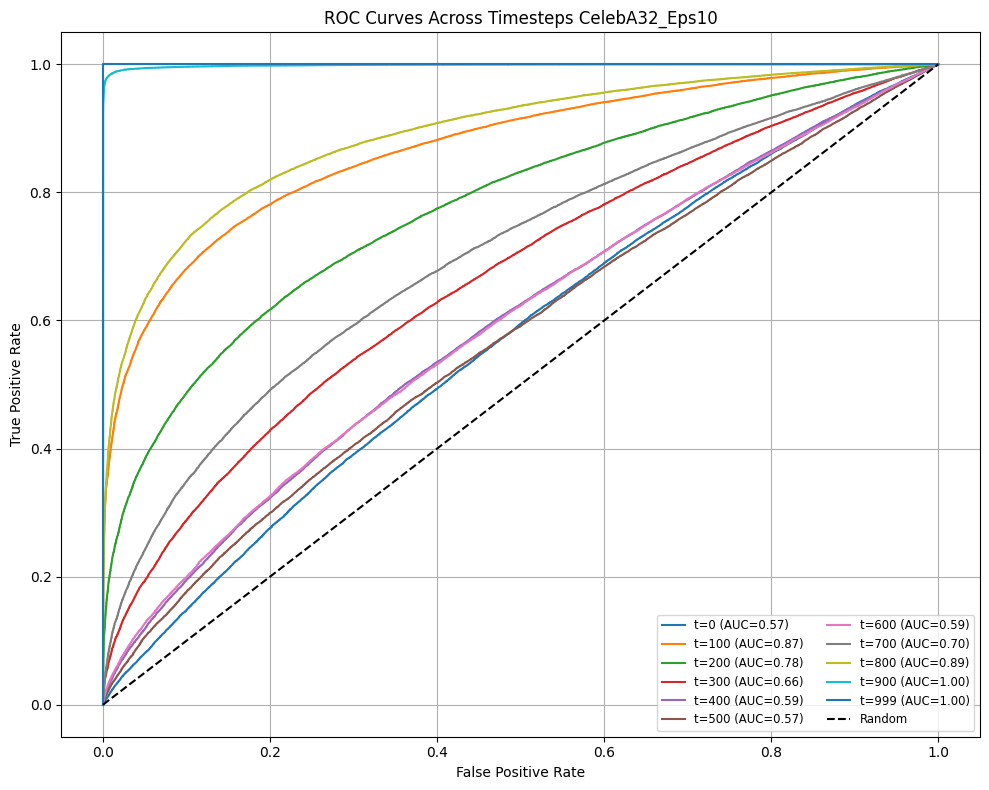

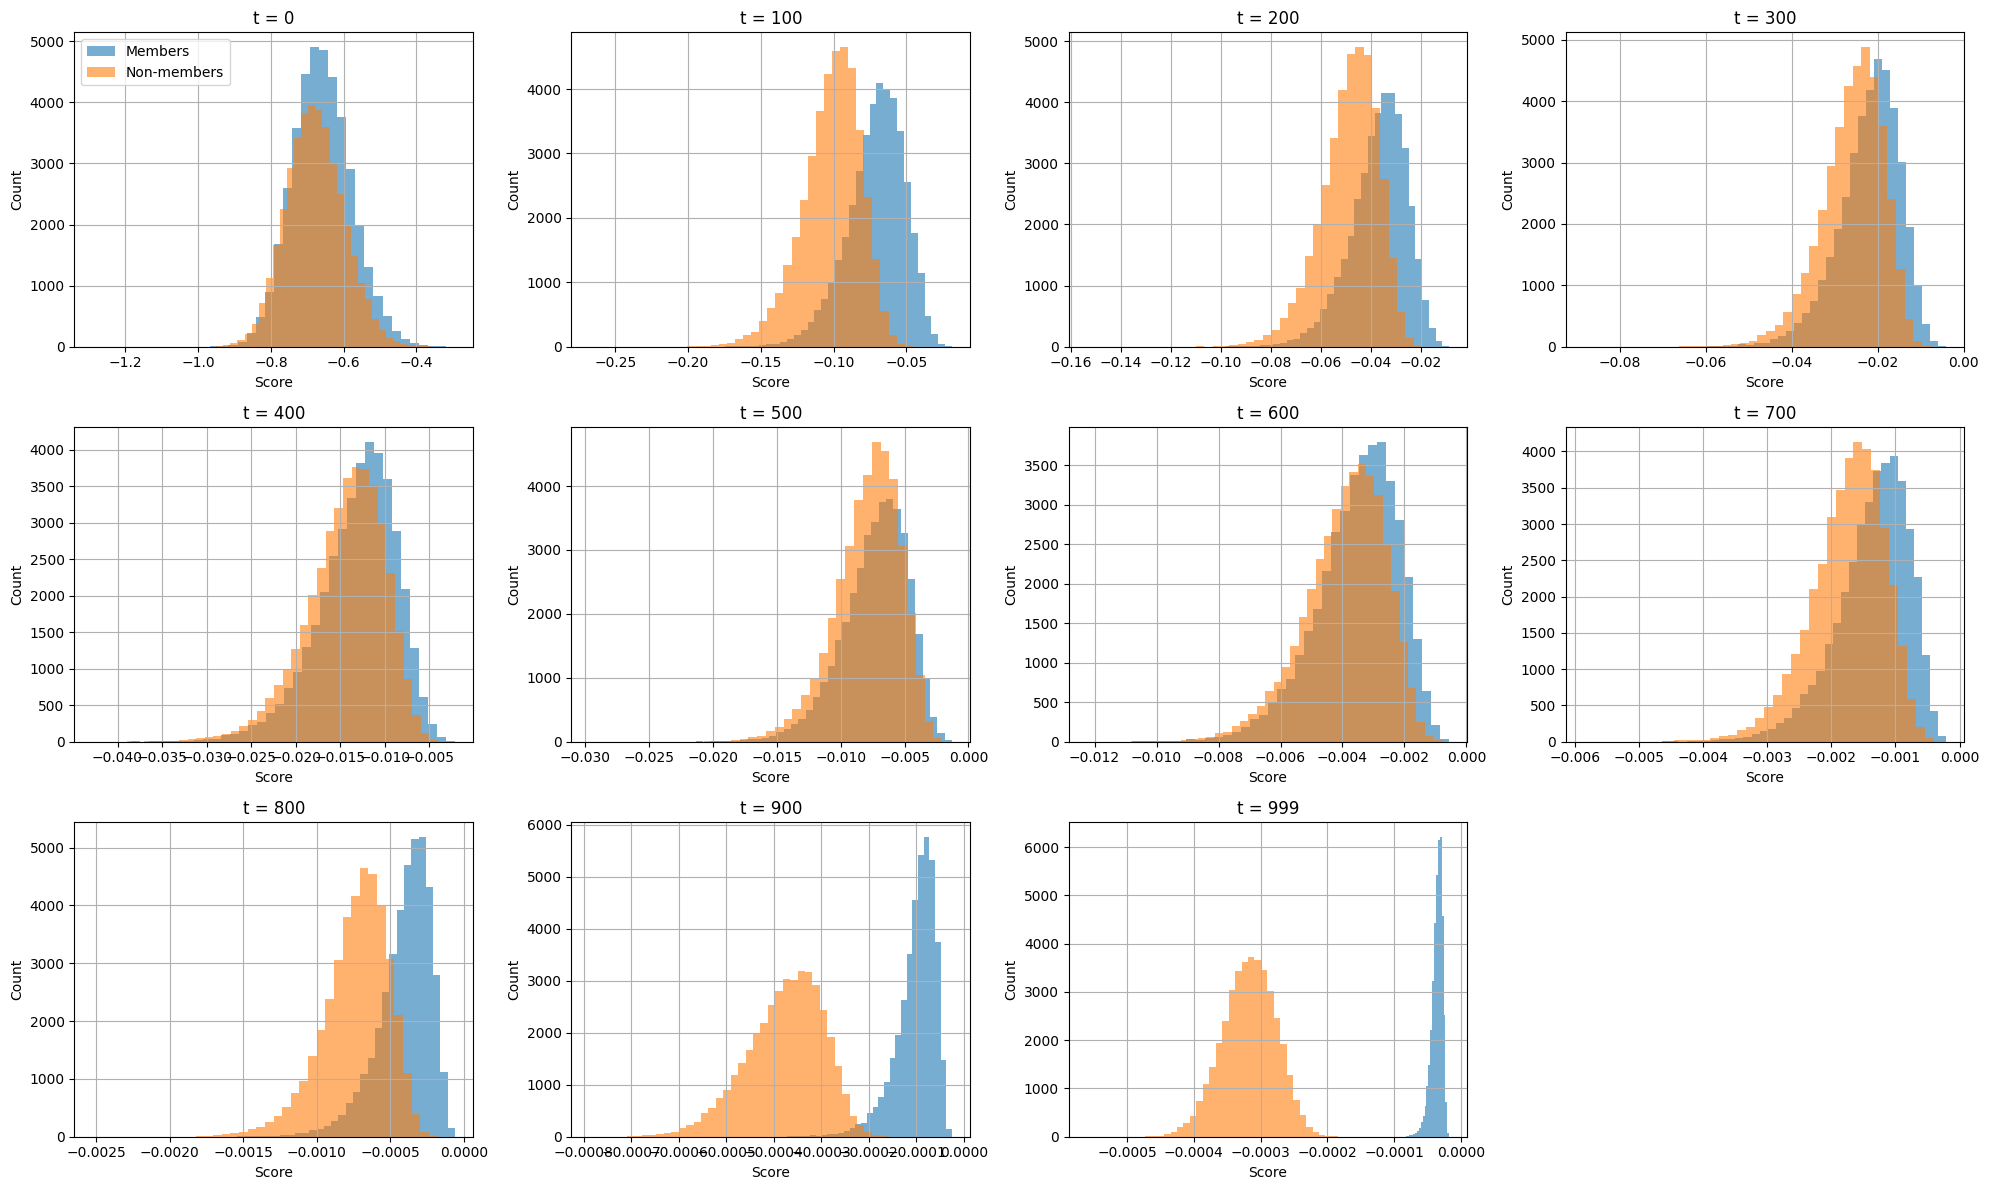


🖼️ Visualizing MEMBER sample


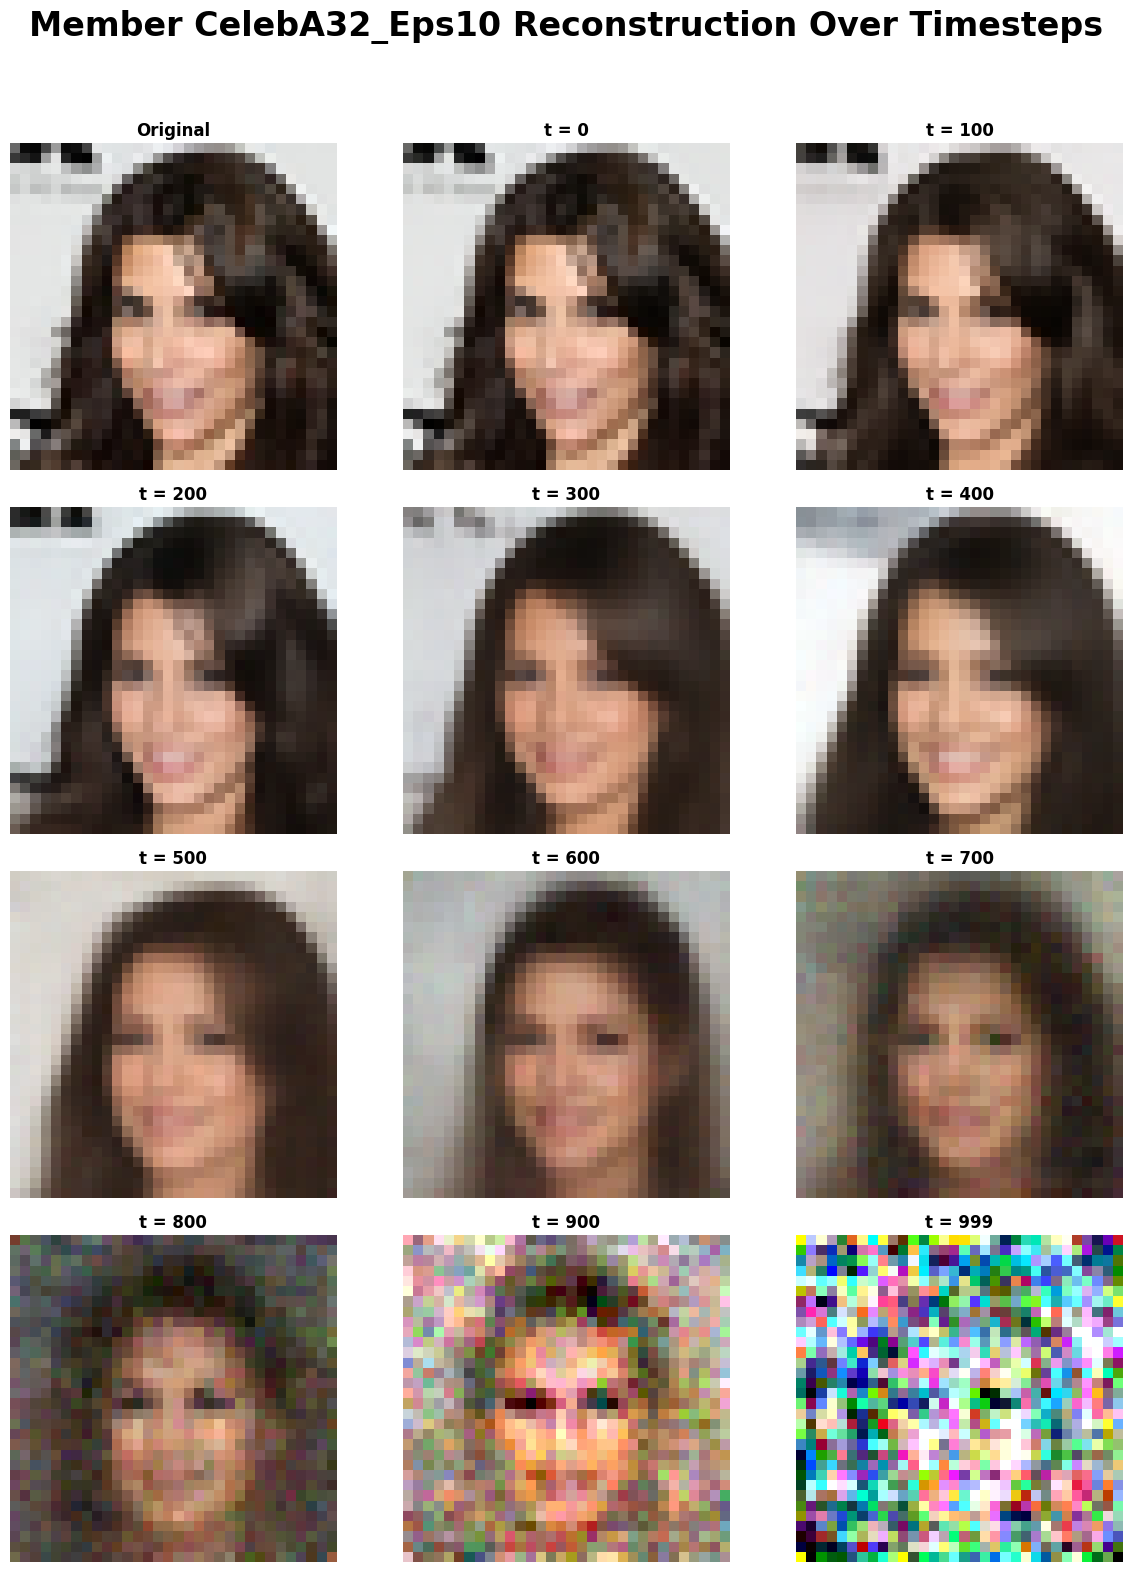


🖼️ Visualizing Non MEMBER sample


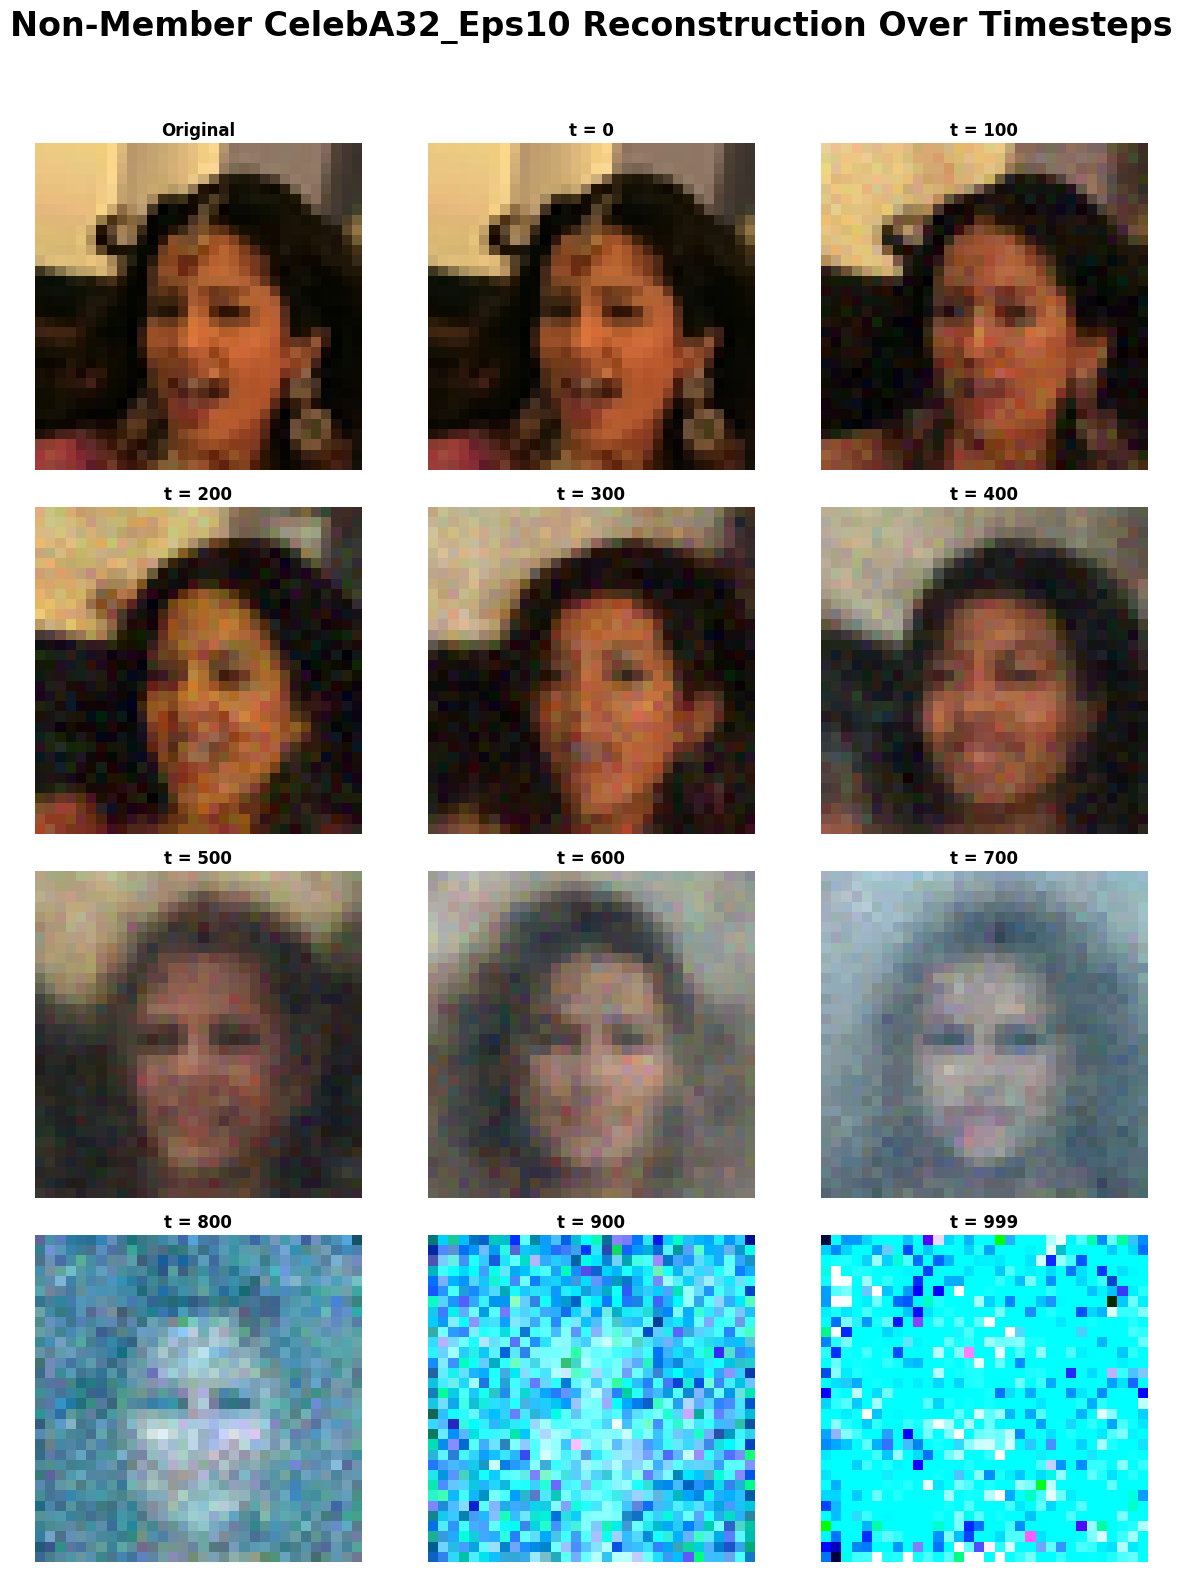

In [29]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf
from torch.utils.data import Subset
import numpy as np
from src.trainers import DPPromiseTrainer
import pandas as pd
import torch.nn.functional as F

# Now import custom modules
#from src.datasets import CustomImageDataset
from src.utils import get_unet_model, seed_everthing
from src.samplers import DDIMSampler

import pandas as pd
from openpyxl import load_workbook
# Define the Excel file path (shared across experiments)
excel_file = "WhiteBoxAttack.xlsx"  # change name per experiment if needed
sheet_name = "CelebA32_Eps10"       # worksheet name for THIS run
# Storage for all timesteps
all_timestep_data = []

from PIL import Image

# --- Settings ---

member_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Train"
nonmember_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/Data/processed/32_Test"
config_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/configs/dp_promise/celeba_32/eps10.0/config.yaml"
ckpt_path = "/rds/projects/c/chenhp-dm-mia/Diff-MIA-Attack/DP-Promise_Github/checkpoints/dp-promise/dp-promise_Train_celeba32_Eps10.0_celeba_eps10.0_0727-19:01:27/checkpoints/ema_30.ckpt"

# --- Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"📡 Using device: {device}")

# --- Config ---
config = OmegaConf.load(config_path)
seed_everthing(config.train.seed)

trainer = DPPromiseTrainer(config).to(device)

# --- Data Transforms ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None, label=0, exclude_files=None):
        self.image_dir = image_dir
        self.transform = transform
        self.label = label

        all_files = [fname for fname in os.listdir(image_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Normalize exclude_files outside the if
        exclude_set = set(f.strip().lower() for f in exclude_files) if exclude_files else set()

        # Exclude files
        filtered_files = [f for f in all_files if f.strip().lower() not in exclude_set]

        self.image_paths = [os.path.join(image_dir, fname) for fname in filtered_files]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.label


overlapping_nonmember_filenames = set([
    "165328.png" , "165694.png" , "166223.png" , "166493.png" , "166699.png" , "167671.png" , "168391.png" ,
    "168593.png" , "169496.png" , "170471.png" , "170604.png" , "170718.png" , "172963.png" , "173340.png" ,
    "175461.png" , "175527.png" , "176462.png" , "177540.png" , "177827.png" , "178379.png" , "179890.png" ,
    "180110.png" , "180455.png" , "180718.png" , "183407.png" , "183446.png" , "183954.png" , "186879.png" ,
    "187543.png" , "189148.png" , "194183.png" , "194529.png" , "195526.png" , "195916.png" , "197808.png" ])

# --- Load Datasets ---

nonmember_dataset = CustomImageDataset(nonmember_path, transform=transform, label=0, exclude_files= overlapping_nonmember_filenames)
member_dataset = CustomImageDataset(member_path, transform=transform, label=1)

# --- Dataset Stats & Sanity Check ---

def print_dataset_summary(dataset, name):
    print(f"\n📊 Dataset: {name}")
    print(f"   Total images loaded: {len(dataset)}")
    print(f"   First 5 image paths:")
    for path in dataset.image_paths[:5]:
        print(f"     - {os.path.basename(path)}")

print_dataset_summary(member_dataset, "Member")
print_dataset_summary(nonmember_dataset, "Non-Member")

# Double check: ensure no overlapping files in nonmember_dataset
nonmember_filenames = set(os.path.basename(p).lower().strip() for p in nonmember_dataset.image_paths)
remaining_overlap = nonmember_filenames & overlapping_nonmember_filenames
print(f"\n🚨 Remaining overlaps in Non-Member dataset: {remaining_overlap if remaining_overlap else 'None'}")

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples to use
sample_size = 40000

# Sample member indices
member_indices = np.random.choice(len(member_dataset), size=sample_size, replace=False)
balanced_member_dataset = Subset(member_dataset, member_indices)
member_loader = DataLoader(balanced_member_dataset, batch_size=32, shuffle=False)

# Sample non-member indices
nonmember_indices = np.random.choice(len(nonmember_dataset), size=sample_size, replace=False)
balanced_nonmember_dataset = Subset(nonmember_dataset, nonmember_indices)
nonmember_loader = DataLoader(balanced_nonmember_dataset, batch_size=32, shuffle=False)

#member_loader = DataLoader(member_dataset, batch_size=512, shuffle=False)
#nonmember_loader = DataLoader(nonmember_dataset, batch_size=512, shuffle=False)

# --- Load Model ---
model = get_unet_model(config).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["state_dict"] if "state_dict" in ckpt else ckpt)
model.eval()

# --- Sampler ---
sampler = DDIMSampler(config)

import torch.nn.functional as F

def get_mia_scores_loss(images, labels, model, sampler, config, device, t_val):
    model.eval()
    scores = []
    batch_size = 64

    if not torch.is_tensor(labels):
        labels = torch.tensor(labels)

    images = images.to(device)
    labels = labels.to(device)

    for i in range(0, images.size(0), batch_size):
        img_batch = images[i:i+batch_size]
        lbl_batch = labels[i:i+batch_size]

        t = torch.full((img_batch.size(0),), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img_batch)
        noisy_img = trainer.q_sample(img_batch, t, noise)

        with torch.no_grad():
            preds = model(noisy_img, t, y=lbl_batch)

        loss = F.mse_loss(preds, noise, reduction='none')
        loss = loss.view(loss.size(0), -1).mean(dim=1)
        scores.extend((-loss).cpu().numpy())

    return scores

# --- Score Extraction ---

def get_all_scores(loader, t_val):
    all_scores = []
    all_labels = []
    for images, labels in tqdm(loader, desc=f"🔄 Processing batches @ t={t_val}"):
        scores = get_mia_scores_loss(images, labels, model, sampler, config, device, t_val)
        all_scores.extend(scores)
        all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    return all_scores, all_labels

@torch.no_grad()
def predict_start_from_noise(x_t, t, noise, alphas_cumprod):
    alphas_cumprod = alphas_cumprod.to(x_t.device)

    # Clamp t to max-1 to avoid out-of-bounds access
    t_safe = torch.clamp(t, max=alphas_cumprod.shape[0] - 2)

    sqrt_alphas_cumprod = alphas_cumprod[t_safe + 1].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod[t_safe + 1]).sqrt().view(-1, 1, 1, 1)

    return (x_t - sqrt_one_minus_alphas_cumprod * noise) / sqrt_alphas_cumprod


def visualize_reconstruction(img, label, model, trainer, t_vals, alphas_cumprod, title_prefix="", save_path="Reconstruction.png"):
    model.eval()
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    num_plots = len(t_vals) + 1  # +1 for original
    num_rows = 4
    num_cols = math.ceil(num_plots / num_rows)  # calculate columns automatically

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axs = axs.flatten()  # flatten to simplify indexing

    # Original image
    axs[0].imshow(((img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
    axs[0].set_title("Original", fontweight='bold')
    axs[0].axis("off")

    # Reconstructions
    for i, t_val in enumerate(t_vals): 
        t = torch.full((1,), t_val, dtype=torch.long).to(device)
        noise = torch.randn_like(img)
        noisy_img = trainer.q_sample(img, t, noise)

        with torch.no_grad():
            pred_noise = model(noisy_img, t, y=label)

        recon_img = predict_start_from_noise(noisy_img, t, pred_noise, alphas_cumprod)
        axs[i + 1].imshow(((recon_img[0].cpu().permute(1, 2, 0) * 0.5) + 0.5).clamp(0, 1))
        axs[i + 1].set_title(f"t = {t_val}", fontweight='bold')
        axs[i + 1].axis("off")

    # Hide any unused subplots
    for j in range(num_plots, len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"{title_prefix} Reconstruction Over Timesteps", fontsize=24, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show() 

timesteps_to_eval = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
results = []
# Store all ROC curves for final combined plot
roc_curves = []  # each element will be (fpr, tpr, auc, timestep)
# For histogram subplots
histogram_data = []  # (timestep, member_scores, nonmember_scores)


for t_val in timesteps_to_eval:
    print(f"\n⏱️ Evaluating timestep t = {t_val}")

    member_scores, member_labels = get_all_scores(member_loader, t_val)
    nonmember_scores, nonmember_labels = get_all_scores(nonmember_loader, t_val)

    y_true = [1]*len(member_scores) + [0]*len(nonmember_scores)
    y_score = member_scores + nonmember_scores

    # Append to list for saving later
    timestep_df = pd.DataFrame({
        "timestep": [t_val] * len(y_true),
        "label": y_true,
        "score": y_score
    })
    all_timestep_data.append(timestep_df)

    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)

    print(f"📈 AUC @ t={t_val}: {auc:.4f}")
    results.append({"timestep": t_val, "auc": auc})
    roc_curves.append((fpr, tpr, auc, t_val))

    histogram_data.append((t_val, member_scores, nonmember_scores))

# After loop — save all timesteps in ONE worksheet
final_df = pd.concat(all_timestep_data, ignore_index=True)

if os.path.exists(excel_file):
    # Append to existing Excel file
    with pd.ExcelWriter(excel_file, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)
else:
    # Create new Excel file
    with pd.ExcelWriter(excel_file, engine="openpyxl") as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ All timestep scores saved to '{excel_file}' in sheet '{sheet_name}'")    
    
# ------------------ Results Table ------------------
results_df = pd.DataFrame(results)
print("\n📊 AUC Scores by Timestep:")
print(results_df.pivot_table(index="timestep", values="auc"))

# Combined ROC plot
plt.figure(figsize=(10, 8))
for fpr, tpr, auc, t in roc_curves:
    plt.plot(fpr, tpr, label=f"t={t} (AUC={auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Timesteps CelebA32_Eps10")
plt.legend(loc="lower right", fontsize="small", ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("CelebA32_Eps10_roc_curves.png")
plt.show()

import math

num_plots = len(histogram_data)
cols = 4
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for idx, (t, member_scores, nonmember_scores) in enumerate(histogram_data):
    plt.subplot(rows, cols, idx + 1)
    plt.hist(member_scores, bins=40, alpha=0.6, label='Members')
    plt.hist(nonmember_scores, bins=40, alpha=0.6, label='Non-members')
    plt.title(f"t = {t}")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.grid(True)
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.savefig("CelebA32_Eps10_histograms.png")
plt.show()


# Get one image from each loader
sample_member_batch = next(iter(member_loader))
sample_nonmember_batch = next(iter(nonmember_loader))

t_vals = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]

alphas_cumprod = torch.cumprod(1. - trainer.betas.float().cpu(), dim=0)


print("\n🖼️ Visualizing MEMBER sample")
visualize_reconstruction(
    sample_member_batch[0][0], sample_member_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Member CelebA32_Eps10", save_path="CelebA32_Eps10_Member_Recon.png"
)

print("\n🖼️ Visualizing Non MEMBER sample")
visualize_reconstruction(
    sample_nonmember_batch[0][0], sample_nonmember_batch[1][0],
    model, trainer, t_vals, alphas_cumprod,
    title_prefix="Non-Member CelebA32_Eps10", save_path="CelebA32_Eps10_Non_Member_Recon.png"
)